In [1]:
!pip install pyspark==3.5.1 spark-nlp==5.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 26.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=09ba73fd4307e356160c94086aacd6b887c191367d35afeae459aa07d8a90b73
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pyspark
print(pyspark.__version__)

3.5.1


In [2]:
## read txt file
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab_CDS527/group project/"  # this is your drive

Mounted at /content/drive/


In [ ]:
# This is only to setup PySpark and Spark NLP on Colab
#!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

In [ ]:
#!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.2.3 -s 5.1.1

In [3]:
import sparknlp
from pyspark.conf import SparkConf
spark = sparknlp.start()

In [4]:
from pyspark.sql.functions import col, regexp_replace, udf, count, sum
import re, string
from pyspark.sql.types import *
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

# Read Data

In [5]:
train_raw = spark.read.csv(data_path + 'train.csv', header=True, inferSchema=True)
test_raw = spark.read.csv(data_path + 'test.csv', header=True, inferSchema=True)
train_raw.show(5)
test_raw.show(5)

+--------+----------+--------------------+---------+
|PhraseId|SentenceId|              Phrase|Sentiment|
+--------+----------+--------------------+---------+
|  144934|      7871|An unremittingly ...|        0|
|  137519|      7440|Makes 98 minutes ...|        0|
|   70201|      3575|-LRB- N -RRB- o m...|        0|
|   19954|       885|An erotic thrille...|        0|
|  101128|      5315|Bray is completel...|        0|
+--------+----------+--------------------+---------+
only showing top 5 rows

+--------+----------+--------------------+---------+
|PhraseId|SentenceId|              Phrase|Sentiment|
+--------+----------+--------------------+---------+
|  108719|      5755|An awful lot like...|        0|
|   33879|      1591|A cellophane-pop ...|        0|
|  142663|      7743|So putrid it is n...|        0|
|  110207|      5837|Most of the movie...|        0|
|   73311|      3745|This one aims for...|        0|
+--------+----------+--------------------+---------+
only showing top 5 ro

In [7]:
train_raw.describe().show()
test_raw.describe().show()

+-------+-----------------+-----------------+--------------------+-----------------+
|summary|         PhraseId|       SentenceId|              Phrase|        Sentiment|
+-------+-----------------+-----------------+--------------------+-----------------+
|  count|              511|              511|                 511|              511|
|   mean|85025.69667318983|4466.583170254403|                NULL|2.064579256360078|
| stddev|44139.82112049152| 2464.87808958182|                NULL|1.280983755342436|
|    min|              214|                8|- spy action flic...|                0|
|    max|           155837|             8531|waydowntown manag...|                4|
+-------+-----------------+-----------------+--------------------+-----------------+

+-------+-----------------+------------------+--------------------+-----------------+
|summary|         PhraseId|        SentenceId|              Phrase|        Sentiment|
+-------+-----------------+------------------+----------------

# Data Preparation


In [6]:
!pip install nltk

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Check empty data of each column

In [7]:
train_raw.agg(*(sum(col(c).isNull().cast("int")).alias(c+'_null_cnt') for c in train_raw.columns)).show()

+-----------------+-------------------+---------------+------------------+
|PhraseId_null_cnt|SentenceId_null_cnt|Phrase_null_cnt|Sentiment_null_cnt|
+-----------------+-------------------+---------------+------------------+
|                0|                  0|              0|                 0|
+-----------------+-------------------+---------------+------------------+



In [8]:
test_raw.agg(*(sum(col(c).isNull().cast("int")).alias(c+'_null_cnt') for c in train_raw.columns)).show()

+-----------------+-------------------+---------------+------------------+
|PhraseId_null_cnt|SentenceId_null_cnt|Phrase_null_cnt|Sentiment_null_cnt|
+-----------------+-------------------+---------------+------------------+
|                0|                  0|              0|                 0|
+-----------------+-------------------+---------------+------------------+



No empty data ​​in both datasets

## Remove noisy data

In [7]:
train_raw = train_raw.withColumn("Phrase", regexp_replace(train_raw["Phrase"], r"-LRB-|-RRB-", ""))
test_raw = test_raw.withColumn("Phrase", regexp_replace(test_raw["Phrase"], r"-LRB-|-RRB-", ""))

In [ ]:
train_raw.show(5)

+--------+----------+--------------------+---------+
|PhraseId|SentenceId|              Phrase|Sentiment|
+--------+----------+--------------------+---------+
|  144934|      7871|An unremittingly ...|        0|
|  137519|      7440|Makes 98 minutes ...|        0|
|   70201|      3575| N  o matter how ...|        0|
|   19954|       885|An erotic thrille...|        0|
|  101128|      5315|Bray is completel...|        0|
+--------+----------+--------------------+---------+
only showing top 5 rows



## SPARKNPL

In [8]:
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover

# Preprocess the text
assembler = DocumentAssembler()\
    .setInputCol('Phrase')\
    .setOutputCol('document')

sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences") \
    .setExplodeSentences(True)

tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')

lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemmas')

normalizer = Normalizer()\
    .setInputCols(['lemmas'])\
    .setOutputCol('normalized')\
    .setLowercase(True)

finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("Phrase_cleaned") \
    .setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

model_data_clean = Pipeline().setStages([assembler, sentence, tokenizer, lemmatizer, normalizer, finisher, sw_remover]).fit(train_raw)
train_cleaned_npl = model_data_clean.transform(train_raw)
test_cleaned_npl = model_data_clean.transform(test_raw)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [11]:
train_cleaned_npl.show(1)
test_cleaned_npl.show(1)

+--------+----------+--------------------+---------+--------------------+--------------------+
|PhraseId|SentenceId|              Phrase|Sentiment|          normalized|      Phrase_cleaned|
+--------+----------+--------------------+---------+--------------------+--------------------+
|  144934|      7871|An unremittingly ...|        0|[an, unremittingl...|[unremittingly, u...|
+--------+----------+--------------------+---------+--------------------+--------------------+
only showing top 1 row

+--------+----------+--------------------+---------+--------------------+--------------------+
|PhraseId|SentenceId|              Phrase|Sentiment|          normalized|      Phrase_cleaned|
+--------+----------+--------------------+---------+--------------------+--------------------+
|  108719|      5755|An awful lot like...|        0|[an, awful, lot, ...|[awful, lot, like...|
+--------+----------+--------------------+---------+--------------------+--------------------+
only showing top 1 row



# BaseLine

Use **sparknpl** to clean data, Use **Word2vec** to vectorize text, Use **Logistic Regression** to analyze data

## Word2vec

In [9]:
from pyspark.ml.feature import Word2Vec
Word2vec = Word2Vec()\
      .setInputCol('Phrase_cleaned')\
      .setOutputCol('word_vectors')\
      .setVectorSize(100)\
      .setMinCount(5)

model_Word2vec = Pipeline().setStages([assembler, sentence, tokenizer, lemmatizer, normalizer, finisher, sw_remover, Word2vec]).fit(train_raw)

train_Word2vec = model_Word2vec.transform(train_raw)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')
test_Word2vec = model_Word2vec.transform(test_raw)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')

In [ ]:
train_Word2vec.show(1)
test_Word2vec.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-9.2028384781716...|    0|
+--------------------+-----+
only showing top 1 row

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-5.9412692644400...|    0|
+--------------------+-----+
only showing top 1 row



## Logistic Regression

In [ ]:
## baseline
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')
model_logr_Word2vec = logr.fit(train_Word2vec)
# Make predictions.
predictions_logr_Word2vec = model_logr_Word2vec.transform(test_Word2vec)

# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logr_Word2vec = evaluator.evaluate(predictions_logr_Word2vec)
print('A Logistic Regression with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_logr_Word2vec*100))

A Logistic Regression with Word2vec had an accuracy of: 22.41%


## Summarize

**Data Cleaning:** First check whether the training data and test data contain null values, then remove the noise data(-LRB- and -RRB-), and finally use SparkNPL to clean the data. The operations for cleaning data include Lemmatization, Normalization and Remove stopwords.

**Baseline Model:** Use Word2vec to vectorize the text, apply the logistic regression model under default parameters, and evaluate the accuracy.

The accuracy of baseline is **22.41%**.

# Model & Evaluation

## Word Embeddings Models

### TF-IDF

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF

# define the tokenizer and CountVectorizer
tf  = CountVectorizer(inputCol="Phrase_cleaned", outputCol="tf") # CountVectorizer count word freq of each doc (i.e., TF)
idf = IDF(inputCol="tf", outputCol="tfidf")

# Alternative: One-step pipeline
pipeline_tfidf = Pipeline(stages=[tf, idf])

In [11]:
model_tfidf_npl = pipeline_tfidf.fit(train_cleaned_npl)

## Train data
train_tfidf_npl = model_tfidf_npl.transform(train_cleaned_npl)
train_tfidf_npl = train_tfidf_npl.withColumnRenamed("tfidf", "features").withColumnRenamed("Sentiment", "label").select('features','label')
train_tfidf_npl.show(1)

## Test data
test_tfidf_npl = model_tfidf_npl.transform(test_cleaned_npl)
test_tfidf_npl = test_tfidf_npl.withColumnRenamed("tfidf", "features").withColumnRenamed("Sentiment", "label").select('features','label')
test_tfidf_npl.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(2495,[0,1,3,26,8...|    0|
+--------------------+-----+
only showing top 1 row

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(2495,[2,6,16,25,...|    0|
+--------------------+-----+
only showing top 1 row



### BERT

In [12]:
bert = BertEmbeddings.pretrained() \
      .setInputCols(["sentences", "normalized"]) \
      .setOutputCol("bert")

model_bert = Pipeline().setStages([assembler, sentence, tokenizer, lemmatizer, normalizer, bert]).fit(train_raw)

train_bert = model_bert.transform(train_raw)\
             .selectExpr('bert.embeddings AS embeddings', 'Sentiment AS label')
test_bert = model_bert.transform(test_raw)\
             .selectExpr('bert.embeddings AS embeddings', 'Sentiment AS label')

small_bert_L2_768 download started this may take some time.
Approximate size to download 135.3 MB
[OK!]


In [ ]:
train_bert.show(1)

+--------------------+-----+
|          embeddings|label|
+--------------------+-----+
|[[0.42229554, 0.3...|    0|
+--------------------+-----+
only showing top 1 row



The Bert processed dataset has empty vectors and the format of the fields is Array(Array(Float())), so we process the empty vectors  first and then convert the format to VectorUDT.

In [13]:
from pyspark.ml.linalg import DenseVector, VectorUDT
## train
train_bert_df = train_bert.toPandas()
train_embeddings_vec = []
for i in train_bert_df['embeddings']:
    train_embeddings_vec.append(np.mean(np.array(i), axis=0))
for i in range(len(train_embeddings_vec)):
    if np.isnan(train_embeddings_vec[i]).any():
        train_embeddings_vec[i] = np.zeros(train_embeddings_vec[1].shape[0])
train_embeddings_vec_d = []
for i in train_embeddings_vec:
    train_embeddings_vec_d.append(DenseVector(i))
train_bert_df['embeddings_vec'] = train_embeddings_vec_d
train_bert_df = train_bert_df.drop("embeddings",axis=1)

train_bert_spdf = spark.createDataFrame(train_bert_df)

## test
test_bert_df = test_bert.toPandas()
test_embeddings_vec = []
for i in test_bert_df['embeddings']:
    test_embeddings_vec.append(np.mean(np.array(i), axis=0))
for i in range(len(test_embeddings_vec)):
    if np.isnan(test_embeddings_vec[i]).any():
        test_embeddings_vec[i] = np.zeros(test_embeddings_vec[1].shape[0])
test_embeddings_vec_d = []
for i in test_embeddings_vec:
    test_embeddings_vec_d.append(DenseVector(i))
test_bert_df['embeddings_vec'] = test_embeddings_vec_d
test_bert_df = test_bert_df.drop("embeddings",axis=1)

test_bert_spdf = spark.createDataFrame(test_bert_df)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
train_bert_spdf = train_bert_spdf.withColumnRenamed("embeddings_vec", "features").select("features", "label")
train_bert_spdf.show(1)
test_bert_spdf = test_bert_spdf.withColumnRenamed("embeddings_vec", "features").select("features", "label")
test_bert_spdf.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.26117731913021...|    0|
+--------------------+-----+
only showing top 1 row

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.47302318410947...|    0|
+--------------------+-----+
only showing top 1 row



### GloVe

In [15]:
glove = WordEmbeddingsModel.pretrained(name='glove_100d') \
    .setInputCols(['document', 'normalized']) \
    .setOutputCol('embeddings')

model_glove = Pipeline().setStages([assembler, sentence, tokenizer, lemmatizer, normalizer, glove]).fit(train_raw)

train_glove = model_glove.transform(train_raw)\
             .selectExpr('embeddings.embeddings AS embeddings', 'Sentiment AS label')
test_glove = model_glove.transform(test_raw)\
             .selectExpr('embeddings.embeddings AS embeddings', 'Sentiment AS label')

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


Same situation as Bert

In [16]:
from pyspark.ml.linalg import DenseVector, VectorUDT
## train
train_glove_df = train_glove.toPandas()
train_embeddings_vec = []
for i in train_glove_df['embeddings']:
    train_embeddings_vec.append(np.mean(np.array(i), axis=0))
for i in range(len(train_embeddings_vec)):
    if np.isnan(train_embeddings_vec[i]).any():
        train_embeddings_vec[i] = np.zeros(100)
train_embeddings_vec_d = []
for i in train_embeddings_vec:
    train_embeddings_vec_d.append(DenseVector(i))
train_glove_df['embeddings_vec'] = train_embeddings_vec_d
train_glove_df = train_glove_df.drop("embeddings",axis=1)

train_glove_spdf = spark.createDataFrame(train_glove_df)

## test
test_glove_df = test_glove.toPandas()
test_embeddings_vec = []
for i in test_glove_df['embeddings']:
    test_embeddings_vec.append(np.mean(np.array(i), axis=0))
for i in range(len(test_embeddings_vec)):
    if np.isnan(test_embeddings_vec[i]).any():
        test_embeddings_vec[i] = np.zeros(100)
test_embeddings_vec_d = []
for i in test_embeddings_vec:
    test_embeddings_vec_d.append(DenseVector(i))
test_glove_df['embeddings_vec'] = test_embeddings_vec_d
test_glove_df = test_glove_df.drop("embeddings",axis=1)

test_glove_spdf = spark.createDataFrame(test_glove_df)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [17]:
train_glove_spdf = train_glove_spdf.withColumnRenamed("embeddings_vec", "features").select("features", "label")
train_glove_spdf.show(1)
test_glove_spdf = test_glove_spdf.withColumnRenamed("embeddings_vec", "features").select("features", "label")
test_glove_spdf.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.0545383447244...|    0|
+--------------------+-----+
only showing top 1 row

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.1076121770174...|    0|
+--------------------+-----+
only showing top 1 row



### Doc2vec

In [18]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# Get the segmented text and labels from train_cleaned_npl
train_data = train_cleaned_npl.select('Phrase_cleaned', 'Sentiment').rdd.map(lambda row: TaggedDocument(words=row['Phrase_cleaned'], tags=[row['Sentiment']])).collect()

# Set the parameters
vector_size = 100
min_count = 2
epochs = 40

# Train Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)
doc2vec_model.build_vocab(train_data)
doc2vec_model.train(train_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Apply Doc2Vec model on train_cleaned_npl
train_embeddings = train_cleaned_npl.rdd.map(lambda row: (DenseVector(doc2vec_model.infer_vector(row["Phrase_cleaned"])), row['Sentiment']))
train_Doc2Vec = spark.createDataFrame(train_embeddings, ['features', 'label'])

# Apply Doc2Vec model on test_cleaned_npl
test_embeddings = test_cleaned_npl.rdd.map(lambda row: (DenseVector(doc2vec_model.infer_vector(row["Phrase_cleaned"])), row['Sentiment']))
test_Doc2Vec = spark.createDataFrame(test_embeddings, ['features', 'label'])

In [ ]:
train_Doc2Vec.show(1)
test_Doc2Vec.show(1)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.2479185909032...|    0|
+--------------------+-----+
only showing top 1 row

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.3948767781257...|    0|
+--------------------+-----+
only showing top 1 row



## Data Analytics Models

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')

In [ ]:
model_logr_tfidf = logr.fit(train_tfidf_npl)
# Make predictions.
predictions_logr_tfidf = model_logr_tfidf.transform(test_tfidf_npl)
predictions_logr_tfidf.select("features", "label", "prediction").show(5)

# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logr_tfidf = evaluator.evaluate(predictions_logr_tfidf)
print('A Logistic Regression with tf-idf had an accuracy of: {0:2.2f}%'.format(accuracy_logr_tfidf*100))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(2495,[2,6,16,25,...|    0|       4.0|
|(2495,[803],[5.78...|    0|       4.0|
|(2495,[8,12,17,37...|    0|       0.0|
|(2495,[0,105,124,...|    0|       1.0|
|(2495,[1,46,102,6...|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

A Logistic Regression with tf-idf had an accuracy of: 25.71%


In [ ]:
## BERT
model_logr_bert = logr.fit(train_bert_spdf)
# Make predictions.
predictions_logr_bert = model_logr_bert.transform(test_bert_spdf)

# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logr_bert = evaluator.evaluate(predictions_logr_bert)
print('A Logistic Regression with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_logr_bert*100))

A Logistic Regression with BERT had an accuracy of: 33.02%


In [ ]:
## GloVe
model_logr_glove = logr.fit(train_glove_spdf)
# Make predictions.
predictions_logr_glove = model_logr_glove.transform(test_glove_spdf)

# Evaluation
accuracy_logr_glove = evaluator.evaluate(predictions_logr_glove)
print('A Logistic Regression with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_logr_glove*100))

A Logistic Regression with GloVe had an accuracy of: 33.25%


In [ ]:
## Doc2vec
model_logr_Doc2vec = logr.fit(train_Doc2Vec)
# Make predictions.
predictions_logr_Doc2vec = model_logr_Doc2vec.transform(test_Doc2Vec)

# Evaluation
accuracy_logr_Doc2vec = evaluator.evaluate(predictions_logr_Doc2vec)
print('A Logistic Regression with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_logr_Doc2vec*100))

A Logistic Regression with Doc2vec had an accuracy of: 27.59%


### Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='features', labelCol='label')

In [ ]:
## TF-IDF
model_nb_tfidf = nb.fit(train_tfidf_npl)
predictions_nb_tfidf = model_nb_tfidf.transform(test_tfidf_npl)
# Evaluation
accuracy_nb_tfidf = evaluator.evaluate(predictions_nb_tfidf)
print('A Naive Bayes with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_nb_tfidf*100))

A Naive Bayes with TF-IDF had an accuracy of: 26.18%


In [ ]:
## BERT
# Naive Bayes requires nonnegative feature value, so use Min-Max Scaling so that all eigenvalues ​​fall within the nonnegative range.
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features"
)

scaler_model_train = scaler.fit(train_bert_spdf)
train_bert_spdf_scaler = scaler_model_train.transform(train_bert_spdf)
train_bert_spdf_scaler = train_bert_spdf_scaler.drop("features")
train_bert_spdf_scaler = train_bert_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_bert_spdf)
test_bert_spdf_scaler = scaler_model_test.transform(test_bert_spdf)
test_bert_spdf_scaler = test_bert_spdf_scaler.drop("features")
test_bert_spdf_scaler = test_bert_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

In [ ]:
model_nb_bert = nb.fit(train_bert_spdf_scaler)
predictions_nb_bert = model_nb_bert.transform(test_bert_spdf_scaler)
# Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_nb_bert = evaluator.evaluate(predictions_nb_bert)
print('A Naive Bayes with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_nb_bert*100))

A Naive Bayes with BERT had an accuracy of: 37.50%


In [ ]:
## GloVe

scaler_model_train = scaler.fit(train_glove_spdf)
train_glove_spdf_scaler = scaler_model_train.transform(train_glove_spdf)
train_glove_spdf_scaler = train_glove_spdf_scaler.drop("features")
train_glove_spdf_scaler = train_glove_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_glove_spdf)
test_glove_spdf_scaler = scaler_model_test.transform(test_glove_spdf)
test_glove_spdf_scaler = test_glove_spdf_scaler.drop("features")
test_glove_spdf_scaler = test_glove_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

model_nb_glove = nb.fit(train_glove_spdf_scaler)
predictions_nb_glove = model_nb_glove.transform(test_glove_spdf_scaler)
# Evaluation
accuracy_nb_glove = evaluator.evaluate(predictions_nb_glove)
print('A Naive Bayes with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_nb_glove*100))

A Naive Bayes with GloVe had an accuracy of: 30.19%


In [ ]:
## Word2vec
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features"
)

scaler_model_train = scaler.fit(train_Word2vec)
train_Word2vec_scaler = scaler_model_train.transform(train_Word2vec)
train_Word2vec_scaler = train_Word2vec_scaler.drop("features")
train_Word2vec_scaler = train_Word2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_Word2vec)
test_Word2vec_scaler = scaler_model_test.transform(test_Word2vec)
test_Word2vec_scaler = test_Word2vec_scaler.drop("features")
test_Word2vec_scaler = test_Word2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

In [ ]:
model_nb_Word2vec = nb.fit(train_Word2vec_scaler)
predictions_nb_Word2vec = model_nb_Word2vec.transform(test_Word2vec_scaler)
# Evaluation
accuracy_nb_Word2vec = evaluator.evaluate(predictions_nb_Word2vec)
print('A Naive Bayes with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_nb_Word2vec*100))

A Naive Bayes with Word2vec had an accuracy of: 26.18%


In [ ]:
## Doc2vec
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler.setMin(0.5)
scaler.setMax(1.5)

scaler_model_train = scaler.fit(train_Doc2Vec)
train_Doc2vec_scaler = scaler_model_train.transform(train_Doc2Vec)
train_Doc2vec_scaler = train_Doc2vec_scaler.drop("features")
train_Doc2vec_scaler = train_Doc2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_Doc2Vec)
test_Doc2vec_scaler = scaler_model_test.transform(test_Doc2Vec)
test_Doc2vec_scaler = test_Doc2vec_scaler.drop("features")
test_Doc2vec_scaler = test_Doc2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

In [ ]:
model_nb_Doc2vec = nb.fit(train_Doc2vec_scaler)
predictions_nb_Doc2vec = model_nb_Doc2vec.transform(test_Doc2vec_scaler)

# Evaluation
accuracy_nb_Doc2vec = evaluator.evaluate(predictions_nb_Doc2vec)
print('A Naive Bayes with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_nb_Doc2vec*100))

A Naive Bayes with Doc2vec had an accuracy of: 30.66%


### KNN

Since pyspark does not have an official KNN, use the KNeighborsClassifier of the sklearn library in python.

In [ ]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
## Evaluation
from sklearn.metrics import accuracy_score
accuracy_knn_tfidf = accuracy_score(y_test, y_pred_knn)
print('A KNN with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_knn_tfidf*100))

A KNN with TF-IDF had an accuracy of: 13.68%


In [ ]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
## Evaluation
from sklearn.metrics import accuracy_score
accuracy_knn_bert = accuracy_score(y_test, y_pred_knn)
print('A KNN with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_knn_bert*100))

A KNN with BERT had an accuracy of: 28.77%


In [ ]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
## Evaluation
from sklearn.metrics import accuracy_score
accuracy_knn_glove = accuracy_score(y_test, y_pred_knn)
print('A KNN with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_knn_glove*100))

A KNN with GloVe had an accuracy of: 26.65%


In [ ]:
## Word2vec
train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
## Evaluation
from sklearn.metrics import accuracy_score
accuracy_knn_Word2vec = accuracy_score(y_test, y_pred_knn)
print('A KNN with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_knn_Word2vec*100))

A KNN with Word2vec had an accuracy of: 24.53%


In [ ]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
## Evaluation
from sklearn.metrics import accuracy_score
accuracy_knn_Doc2vec = accuracy_score(y_test, y_pred_knn)
print('A KNN with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_knn_Doc2vec*100))

A KNN with Doc2vec had an accuracy of: 23.58%


### Multi-class AdaBoost

Since pyspark does not have an official AdaBoost, use the AdaBoostClassifier of the sklearn library in python.

In [ ]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
multi_class_adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=100)
multi_class_adaBoost.fit(X_train, y_train)
y_pred_adaBoost = multi_class_adaBoost.predict(X_test)

## Evaluation
from sklearn.metrics import accuracy_score
accuracy_adaBoost_tfidf = accuracy_score(y_test, y_pred_adaBoost)
print('An AdaBoost with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_adaBoost_tfidf*100))

An AdaBoost with TF-IDF had an accuracy of: 23.82%


In [ ]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
multi_class_adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=100)
multi_class_adaBoost.fit(X_train, y_train)
y_pred_adaBoost = multi_class_adaBoost.predict(X_test)

## Evaluation
from sklearn.metrics import accuracy_score
accuracy_adaBoost_bert = accuracy_score(y_test, y_pred_adaBoost)
print('An AdaBoost with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_adaBoost_bert*100))

An AdaBoost with BERT had an accuracy of: 29.25%


In [ ]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
multi_class_adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=100)
multi_class_adaBoost.fit(X_train, y_train)
y_pred_adaBoost = multi_class_adaBoost.predict(X_test)

## Evaluation
from sklearn.metrics import accuracy_score
accuracy_adaBoost_glove = accuracy_score(y_test, y_pred_adaBoost)
print('An AdaBoost with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_adaBoost_glove*100))

An AdaBoost with GloVe had an accuracy of: 30.19%


In [ ]:
## Word2vec
train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
multi_class_adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=100)
multi_class_adaBoost.fit(X_train, y_train)
y_pred_adaBoost = multi_class_adaBoost.predict(X_test)

## Evaluation
from sklearn.metrics import accuracy_score
accuracy_adaBoost_Word2vec = accuracy_score(y_test, y_pred_adaBoost)
print('An AdaBoost with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_adaBoost_Word2vec*100))

An AdaBoost with Word2vec had an accuracy of: 27.36%


In [ ]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=1)
multi_class_adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=100)
multi_class_adaBoost.fit(X_train, y_train)
y_pred_adaBoost = multi_class_adaBoost.predict(X_test)

## Evaluation
from sklearn.metrics import accuracy_score
accuracy_adaBoost_Doc2vec = accuracy_score(y_test, y_pred_adaBoost)
print('An AdaBoost with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_adaBoost_Doc2vec*100))

An AdaBoost with Doc2vec had an accuracy of: 23.11%


### Decision Tree

In [ ]:
## TF-IDF
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
model_dtc = dtc.fit(train_tfidf_npl)
predictions_dtc = model_dtc.transform(test_tfidf_npl)
# Evaluation
accuracy_dtc_tfidf = evaluator.evaluate(predictions_dtc)
print('A single decision tree with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_dtc_tfidf*100))

A single decision tree with TF-IDF had an accuracy of: 26.42%


In [ ]:
## BERT
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
model_dtc = dtc.fit(train_bert_spdf)
predictions_dtc = model_dtc.transform(test_bert_spdf)
# Evaluation
accuracy_dtc_bert = evaluator.evaluate(predictions_dtc)
print('A single decision tree with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_dtc_bert*100))

A single decision tree with BERT had an accuracy of: 25.71%


In [ ]:
## GloVe
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
model_dtc = dtc.fit(train_glove_spdf)
predictions_dtc = model_dtc.transform(test_glove_spdf)
# Evaluation
accuracy_dtc_glove = evaluator.evaluate(predictions_dtc)
print('A single decision tree with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_dtc_glove*100))

A single decision tree with GloVe had an accuracy of: 28.07%


In [ ]:
## Word2vec
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
model_dtc = dtc.fit(train_Word2vec)
predictions_dtc = model_dtc.transform(test_Word2vec)
# Evaluation
accuracy_dtc_Word2vec = evaluator.evaluate(predictions_dtc)
print('A single decision tree with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_dtc_Word2vec*100))

A single decision tree with Word2vec had an accuracy of: 29.72%


In [ ]:
## Doc2vec
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
model_dtc = dtc.fit(train_Doc2Vec)
predictions_dtc = model_dtc.transform(test_Doc2Vec)
# Evaluation
accuracy_dtc_Doc2vec = evaluator.evaluate(predictions_dtc)
print('A single decision tree with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_dtc_Doc2vec*100))

A single decision tree with Doc2vec had an accuracy of: 25.71%


### Random Forest

In [ ]:
## TF-IDF
from pyspark.ml.classification import RandomForestClassifier
rdc = RandomForestClassifier(featuresCol='features', labelCol='label')
model_rdc = rdc.fit(train_tfidf_npl)
predictions_rdc = model_rdc.transform(test_tfidf_npl)
# Evaluation
accuracy_rdc_tfidf = evaluator.evaluate(predictions_rdc)
print('A Random Forest with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_rdc_tfidf*100))

A Random Forest with TF-IDF had an accuracy of: 27.12%


In [ ]:
## BERT
from pyspark.ml.classification import RandomForestClassifier
rdc = RandomForestClassifier(featuresCol='features', labelCol='label')
model_rdc = rdc.fit(train_bert_spdf)
predictions_rdc = model_rdc.transform(test_bert_spdf)
# Evaluation
accuracy_rdc_bert = evaluator.evaluate(predictions_rdc)
print('A Random Forest with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_rdc_bert*100))

A Random Forest with BERT had an accuracy of: 35.38%


In [ ]:
## GloVe
from pyspark.ml.classification import RandomForestClassifier
rdc = RandomForestClassifier(featuresCol='features', labelCol='label')
model_rdc = rdc.fit(train_glove_spdf)
predictions_rdc = model_rdc.transform(test_glove_spdf)
# Evaluation
accuracy_rdc_glove = evaluator.evaluate(predictions_rdc)
print('A Random Forest with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_rdc_glove*100))

A Random Forest with GloVe had an accuracy of: 29.95%


In [ ]:
## Word2vec
from pyspark.ml.classification import RandomForestClassifier
rdc = RandomForestClassifier(featuresCol='features', labelCol='label')
model_rdc = rdc.fit(train_Word2vec)
predictions_rdc = model_rdc.transform(test_Word2vec)
# Evaluation
accuracy_rdc_Word2vec = evaluator.evaluate(predictions_rdc)
print('A Random Forest with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_rdc_Word2vec*100))

A Random Forest with Word2vec had an accuracy of: 30.42%


In [ ]:
## Doc2vec
from pyspark.ml.classification import RandomForestClassifier
rdc = RandomForestClassifier(featuresCol='features', labelCol='label')
model_rdc = rdc.fit(train_Doc2Vec)
predictions_rdc = model_rdc.transform(test_Doc2Vec)
# Evaluation
accuracy_rdc_Doc2vec = evaluator.evaluate(predictions_rdc)
print('A Random Forest with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_rdc_Doc2vec*100))

A Random Forest with Doc2vec had an accuracy of: 24.76%


### Gradient Boosting

Since Gradient Boosting requires that the label value can only be 0 or 1, OneVsRest is used to convert the multi-class classification problem into a combination of multiple binary classification problems.

In [ ]:
## TF-IDF
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)
model_gbtc = ovr_gbtc.fit(train_tfidf_npl)
predictions_gbtc = model_gbtc.transform(test_tfidf_npl)
# Evaluation
accuracy_gbtc_tfidf = evaluator.evaluate(predictions_gbtc)
print('A Gradient Boosting with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_gbtc_tfidf*100))

A Gradient Boosting with TF-IDF had an accuracy of: 28.77%


In [ ]:
## BERT
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)
model_gbtc = ovr_gbtc.fit(train_bert_spdf)
predictions_gbtc = model_gbtc.transform(test_bert_spdf)
# Evaluation
accuracy_gbtc_bert = evaluator.evaluate(predictions_gbtc)
print('A Gradient Boosting with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_gbtc_bert*100))

A Gradient Boosting with BERT had an accuracy of: 29.48%


In [ ]:
## GloVe
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)
model_gbtc = ovr_gbtc.fit(train_glove_spdf)
predictions_gbtc = model_gbtc.transform(test_glove_spdf)
# Evaluation
accuracy_gbtc_glove = evaluator.evaluate(predictions_gbtc)
print('A Gradient Boosting with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_gbtc_glove*100))

A Gradient Boosting with GloVe had an accuracy of: 27.12%


In [ ]:
## Word2vec
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)
model_gbtc = ovr_gbtc.fit(train_Word2vec)
predictions_gbtc = model_gbtc.transform(test_Word2vec)
# Evaluation
accuracy_gbtc_Word2vec = evaluator.evaluate(predictions_gbtc)
print('A Gradient Boosting with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_gbtc_Word2vec*100))

A Gradient Boosting with Word2vec had an accuracy of: 22.41%


In [ ]:
## Doc2vec
from pyspark.ml.classification import GBTClassifier, OneVsRest
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)
model_gbtc = ovr_gbtc.fit(train_Doc2Vec)
predictions_gbtc = model_gbtc.transform(test_Doc2Vec)
# Evaluation
accuracy_gbtc_Doc2vec = evaluator.evaluate(predictions_gbtc)
print('A Gradient Boosting with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_gbtc_Doc2vec*100))

A Gradient Boosting with Doc2vec had an accuracy of: 24.53%


### XGBoost

Since pyspark does not have an official XGBoost, use the XGBClassifier of the xgboost library in python.

In [ ]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
## Evaluation
accuracy_xgb_tfidf = accuracy_score(y_test, y_pred)
print('A XGBoost with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_xgb_tfidf*100))

A XGBoost with TF-IDF had an accuracy of: 26.89%


In [ ]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
## Evaluation
accuracy_xgb_bert = accuracy_score(y_test, y_pred)
print('A XGBoost with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_xgb_bert*100))

A XGBoost with BERT had an accuracy of: 29.72%


In [ ]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
## Evaluation
accuracy_xgb_glove = accuracy_score(y_test, y_pred)
print('A XGBoost with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_xgb_glove*100))

A XGBoost with GloVe had an accuracy of: 31.60%


In [ ]:
## Word2vec
train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()


from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
## Evaluation
accuracy_xgb_Word2vec = accuracy_score(y_test, y_pred)
print('A XGBoost with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_xgb_Word2vec*100))

A XGBoost with Word2vec had an accuracy of: 28.30%


In [ ]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
## Evaluation
accuracy_xgb_Doc2vec = accuracy_score(y_test, y_pred)
print('A XGBoost with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_xgb_Doc2vec*100))

A XGBoost with Doc2vec had an accuracy of: 24.76%


### Linear Support Vector Machine
Since SVM requires that the label value can only be 0 or 1, OneVsRest is used to convert the multi-class classification problem into a combination of multiple binary classification problems.


In [ ]:
## TF-IDF
from pyspark.ml.classification import LinearSVC, OneVsRest
svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)
model_svm = ovr_svm.fit(train_tfidf_npl)
predictions_svm = model_svm.transform(test_tfidf_npl)
# Evaluation
accuracy_svm_tfidf = evaluator.evaluate(predictions_svm)
print('A SVM with TF-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_svm_tfidf*100))

A SVM with TF-IDF had an accuracy of: 28.77%


In [ ]:
## BERT
from pyspark.ml.classification import LinearSVC, OneVsRest
svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)
model_svm = ovr_svm.fit(train_bert_spdf)
predictions_svm = model_svm.transform(test_bert_spdf)
# Evaluation
accuracy_svm_bert = evaluator.evaluate(predictions_svm)
print('A SVM with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_svm_bert*100))

A SVM with BERT had an accuracy of: 27.59%


In [ ]:
## GloVe
from pyspark.ml.classification import LinearSVC, OneVsRest
svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)
model_svm = ovr_svm.fit(train_glove_spdf)
predictions_svm = model_svm.transform(test_glove_spdf)
# Evaluation
accuracy_svm_glove = evaluator.evaluate(predictions_svm)
print('A SVM with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_svm_glove*100))

A SVM with GloVe had an accuracy of: 31.60%


In [ ]:
## Word2vec
from pyspark.ml.classification import LinearSVC, OneVsRest
svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)
model_svm = ovr_svm.fit(train_Word2vec)
predictions_svm = model_svm.transform(test_Word2vec)
# Evaluation
accuracy_svm_Word2vec = evaluator.evaluate(predictions_svm)
print('A SVM with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_svm_Word2vec*100))

A SVM with Word2vec had an accuracy of: 23.35%


In [ ]:
## Doc2vec
from pyspark.ml.classification import LinearSVC, OneVsRest
svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)
model_svm = ovr_svm.fit(train_Doc2Vec)
predictions_svm = model_svm.transform(test_Doc2Vec)
# Evaluation
accuracy_svm_Doc2vec = evaluator.evaluate(predictions_svm)
print('A SVM with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_svm_Doc2vec*100))

A SVM with Doc2vec had an accuracy of: 29.01%


### Neural Network

In [ ]:
## TF-IDF
# Gets the length of the feature vector
first_row = train_tfidf_npl.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
from pyspark.ml.classification import MultilayerPerceptronClassifier
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)
model_mlp = mlp.fit(train_tfidf_npl)
predictions_mlp = model_mlp.transform(test_tfidf_npl)
# Evaluation
accuracy_mlp_tfidf = evaluator.evaluate(predictions_mlp)
print('A single neural network with Tf-IDF had an accuracy of: {0:2.2f}%'.format(accuracy_mlp_tfidf*100))

A single neural network with Tf-IDF had an accuracy of: 28.30%


In [ ]:
## BERT
# Gets the length of the feature vector
first_row = train_bert_spdf.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
from pyspark.ml.classification import MultilayerPerceptronClassifier
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)
model_mlp = mlp.fit(train_bert_spdf)
predictions_mlp = model_mlp.transform(test_bert_spdf)
# Evaluation
accuracy_mlp_bert = evaluator.evaluate(predictions_mlp)
print('A single neural network with BERT had an accuracy of: {0:2.2f}%'.format(accuracy_mlp_bert*100))

A single neural network with BERT had an accuracy of: 34.20%


In [ ]:
## GloVe
# Gets the length of the feature vector
first_row = train_glove_spdf.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
from pyspark.ml.classification import MultilayerPerceptronClassifier
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)
model_mlp = mlp.fit(train_glove_spdf)
predictions_mlp = model_mlp.transform(test_glove_spdf)
# Evaluation
accuracy_mlp_glove = evaluator.evaluate(predictions_mlp)
print('A single neural network with GloVe had an accuracy of: {0:2.2f}%'.format(accuracy_mlp_glove*100))

A single neural network with GloVe had an accuracy of: 29.72%


In [ ]:
## Word2vec
from pyspark.ml.classification import MultilayerPerceptronClassifier
input_size = 100
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)
model_mlp = mlp.fit(train_Word2vec)
predictions_mlp = model_mlp.transform(test_Word2vec)
# Evaluation
accuracy_mlp_Word2vec = evaluator.evaluate(predictions_mlp)
print('A single neural network with Word2vec had an accuracy of: {0:2.2f}%'.format(accuracy_mlp_bert*100))

A single neural network with Word2vec had an accuracy of: 34.20%


In [ ]:
## Doc2vec
from pyspark.ml.classification import MultilayerPerceptronClassifier
input_size = 100
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)
model_mlp = mlp.fit(train_Doc2Vec)
predictions_mlp = model_mlp.transform(test_Doc2Vec)
# Evaluation
accuracy_mlp_Doc2vec = evaluator.evaluate(predictions_mlp)
print('A single neural network with Doc2vec had an accuracy of: {0:2.2f}%'.format(accuracy_mlp_Doc2vec*100))

A single neural network with Doc2vec had an accuracy of: 25.00%


## Summarize
In total, use 5 word embeddings models and 10 data analytice models.

|Word Embeddings Models|
-
|TF-IDF|
|BERT|
|GloVe|
|Word2vec|
|Doc2vec|

|Data Analytics Models|
-
|Logistic Regression|
|Naive Bayes|
|KNN|
|AdaBoost|
|Decision Tree|
|Random Forest|
|Gradient Boosting|
|XGBoost|
|Linear Support Vector Machine|
|neural Network|

5 Word Embeddings Models were used to vectorize the text and apply it to 10 data analysis models, and finally get 50 accuracies.

1. Naive Bayes performed **best** overall.

2. The Naive Bayes model using BERT to process text has the **highest** accuracy.

3. The KNN model using TF-IDF to process text has the **lowest** accuracy.


In [ ]:
## Model Performance
da_model_list = ['LogReg','NaiveBayes','KNN','AdaBoost','DecisionTree','RandomForest','GradientBoosting','XGBoost','SVM','NeuralNetwork']
we_model_list = ['TF-IDF','BERT','GloVe','Word2vec','Doc2vec']
da_model_abb_list = ['logr','nb','knn','adaBoost','dtc','rdc','gbtc','xgb','svm','mlp']
we_model_abb_list = ['tfidf','bert','glove','Word2vec','Doc2vec']

data = []
for x in range(len(we_model_abb_list)):
    temp = []
    for y in range(len(da_model_abb_list)):
        name = 'accuracy_' + da_model_abb_list[y] + '_' + we_model_abb_list[x]
        temp.append(eval(name)*100)  # 使用eval函数获取变量的值
    data.append(temp)

df = pd.DataFrame(data, columns=da_model_list, index=we_model_list)

average_accuracy = df.mean()
df.loc["average accuracy"] = average_accuracy

df

,LogReg,NaiveBayes,KNN,AdaBoost,DecisionTree,RandomForest,GradientBoosting,XGBoost,SVM,NeuralNetwork
TF-IDF,25.707547,26.179245,13.679245,23.820755,26.415094,27.122642,28.773585,26.886792,28.773585,28.301887
BERT,33.018868,37.500000,28.773585,29.245283,25.707547,35.377358,29.481132,29.716981,27.594340,34.198113
GloVe,33.254717,30.188679,26.650943,30.188679,28.066038,29.952830,27.122642,31.603774,31.603774,29.716981
Word2vec,22.405660,26.179245,24.528302,27.358491,29.716981,30.424528,22.405660,28.301887,23.349057,25.471698
Doc2vec,28.301887,30.660377,23.584906,23.113208,25.707547,24.764151,24.528302,24.764151,29.009434,25.000000
average accuracy,28.537736,30.141509,23.443396,26.745283,27.122642,29.528302,26.462264,28.254717,28.066038,28.537736


In [ ]:
## save data
df.to_csv(data_path+'model performance.csv', index=False)

# Hyper-parameters

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

## Logistic Regression

In [22]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')

In [25]:
## tfidf
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
cv_model = crossval.fit(train_tfidf_npl)
predictions = cv_model.transform(test_tfidf_npl)
accuracy_logr_tfidf_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_logr_tfidf_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with TF-IDF accuracy: 29.01%
Best model hyperparameters:
- regParam: 1.0
- elasticNetParam: 0.0


In [26]:
## bert
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
cv_model = crossval.fit(train_bert_spdf)
predictions = cv_model.transform(test_bert_spdf)
accuracy_logr_bert_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with BERT accuracy: {0:2.2f}%'.format(accuracy_logr_bert_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with BERT accuracy: 35.85%
Best model hyperparameters:
- regParam: 1.0
- elasticNetParam: 0.0


In [27]:
## GloVe
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
cv_model = crossval.fit(train_glove_spdf)
predictions = cv_model.transform(test_glove_spdf)
accuracy_logr_glove_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with GloVe accuracy: {0:2.2f}%'.format(accuracy_logr_glove_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with GloVe accuracy: 34.43%
Best model hyperparameters:
- regParam: 1.0
- elasticNetParam: 0.0


In [28]:
## Word2vec
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
cv_model = crossval.fit(train_Word2vec)
predictions = cv_model.transform(test_Word2vec)
accuracy_logr_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with Word2vec accuracy: {0:2.2f}%'.format(accuracy_logr_Word2vec_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with Word2vec accuracy: 24.53%
Best model hyperparameters:
- regParam: 1.0
- elasticNetParam: 0.0


In [29]:
## Doc2vec
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
cv_model = crossval.fit(train_Doc2Vec)
predictions = cv_model.transform(test_Doc2Vec)
accuracy_logr_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_logr_Doc2vec_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with Doc2vec accuracy: 28.77%
Best model hyperparameters:
- regParam: 0.01
- elasticNetParam: 0.0


## Naive Bayes

In [30]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='features', labelCol='label')

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.1, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

In [31]:
## TF-IDF
cv_model = crossval.fit(train_tfidf_npl)
predictions = cv_model.transform(test_tfidf_npl)
accuracy_nb_tfidf_hp = evaluator.evaluate(predictions)
print('Best Naive Bayes with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_nb_tfidf_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_smoothing = best_model.getOrDefault('smoothing')
print('Best model hyperparameters:')
print('- Smoothing:', best_smoothing)

Best Naive Bayes with TF-IDF accuracy: 26.18%
Best model hyperparameters:
- Smoothing: 1.0


In [32]:
## BERT
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features"
)

scaler_model_train = scaler.fit(train_bert_spdf)
train_bert_spdf_scaler = scaler_model_train.transform(train_bert_spdf)
train_bert_spdf_scaler = train_bert_spdf_scaler.drop("features")
train_bert_spdf_scaler = train_bert_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_bert_spdf)
test_bert_spdf_scaler = scaler_model_test.transform(test_bert_spdf)
test_bert_spdf_scaler = test_bert_spdf_scaler.drop("features")
test_bert_spdf_scaler = test_bert_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

cv_model = crossval.fit(train_bert_spdf_scaler)
predictions = cv_model.transform(test_bert_spdf_scaler)
accuracy_nb_bert_hp = evaluator.evaluate(predictions)
print('Best Naive Bayes with BERT accuracy: {0:2.2f}%'.format(accuracy_nb_bert_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_smoothing = best_model.getOrDefault('smoothing')
print('Best model hyperparameters:')
print('- Smoothing:', best_smoothing)

Best Naive Bayes with BERT accuracy: 37.26%
Best model hyperparameters:
- Smoothing: 0.1


In [33]:
## GloVe
scaler_model_train = scaler.fit(train_glove_spdf)
train_glove_spdf_scaler = scaler_model_train.transform(train_glove_spdf)
train_glove_spdf_scaler = train_glove_spdf_scaler.drop("features")
train_glove_spdf_scaler = train_glove_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_glove_spdf)
test_glove_spdf_scaler = scaler_model_test.transform(test_glove_spdf)
test_glove_spdf_scaler = test_glove_spdf_scaler.drop("features")
test_glove_spdf_scaler = test_glove_spdf_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

cv_model = crossval.fit(train_glove_spdf_scaler)
predictions = cv_model.transform(test_glove_spdf_scaler)
accuracy_nb_glove_hp = evaluator.evaluate(predictions)
print('Best Naive Bayes with GloVe accuracy: {0:2.2f}%'.format(accuracy_nb_glove_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_smoothing = best_model.getOrDefault('smoothing')
print('Best model hyperparameters:')
print('- Smoothing:', best_smoothing)

Best Naive Bayes with GloVe accuracy: 30.42%
Best model hyperparameters:
- Smoothing: 0.1


In [36]:
## Word2vec
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(
    inputCol="features",
    outputCol="scaled_features"
)

scaler_model_train = scaler.fit(train_Word2vec)
train_Word2vec_scaler = scaler_model_train.transform(train_Word2vec)
train_Word2vec_scaler = train_Word2vec_scaler.drop("features")
train_Word2vec_scaler = train_Word2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_Word2vec)
test_Word2vec_scaler = scaler_model_test.transform(test_Word2vec)
test_Word2vec_scaler = test_Word2vec_scaler.drop("features")
test_Word2vec_scaler = test_Word2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

cv_model = crossval.fit(train_Word2vec_scaler)
predictions = cv_model.transform(test_Word2vec_scaler)
accuracy_nb_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Naive Bayes with Word2vec accuracy: {0:2.2f}%'.format(accuracy_nb_Word2vec_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_smoothing = best_model.getOrDefault('smoothing')
print('Best model hyperparameters:')
print('- Smoothing:', best_smoothing)

Best Naive Bayes with Word2vec accuracy: 27.12%
Best model hyperparameters:
- Smoothing: 0.1


In [37]:
## Doc2vec
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler.setMin(0.5)
scaler.setMax(1.5)

scaler_model_train = scaler.fit(train_Doc2Vec)
train_Doc2vec_scaler = scaler_model_train.transform(train_Doc2Vec)
train_Doc2vec_scaler = train_Doc2vec_scaler.drop("features")
train_Doc2vec_scaler = train_Doc2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

scaler_model_test = scaler.fit(test_Doc2Vec)
test_Doc2vec_scaler = scaler_model_test.transform(test_Doc2Vec)
test_Doc2vec_scaler = test_Doc2vec_scaler.drop("features")
test_Doc2vec_scaler = test_Doc2vec_scaler.withColumnRenamed("scaled_features", "features").select('features','label')

cv_model = crossval.fit(train_Doc2vec_scaler)
predictions = cv_model.transform(test_Doc2vec_scaler)
accuracy_nb_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Naive Bayes with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_nb_Doc2vec_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_smoothing = best_model.getOrDefault('smoothing')
print('Best model hyperparameters:')
print('- Smoothing:', best_smoothing)

Best Naive Bayes with Doc2vec accuracy: 31.37%
Best model hyperparameters:
- Smoothing: 1.0


## KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn.metrics import accuracy_score

In [39]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

n_neighbors = [3, 5, 7, 9, 11]
accuracy_scores = []

for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

accuracy_knn_tfidf_hp = max(accuracy_scores)
best_n_neighbor = n_neighbors[accuracy_scores.index(accuracy_knn_tfidf_hp)]

print('Best KNN with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_knn_tfidf_hp * 100))
# get the best hyper-parameter
print('Best model hyperparameters:')
print('- Corresponding n_neighbors:', best_n_neighbor)

Best KNN with TF-IDF accuracy: 13.68%
Best model hyperparameters:
- Corresponding n_neighbors: 3


In [40]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

n_neighbors = [3, 5, 7, 9, 11]
accuracy_scores = []

for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

accuracy_knn_bert_hp = max(accuracy_scores)
best_n_neighbor = n_neighbors[accuracy_scores.index(accuracy_knn_bert_hp)]

print('Best KNN with BERT accuracy: {0:2.2f}%'.format(accuracy_knn_bert_hp * 100))
# get the best hyper-parameter
print('Best model hyperparameters:')
print('- Corresponding n_neighbors:', best_n_neighbor)

Best KNN with BERT accuracy: 30.90%
Best model hyperparameters:
- Corresponding n_neighbors: 11


In [41]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

n_neighbors = [3, 5, 7, 9, 11]
accuracy_scores = []

for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

accuracy_knn_glove_hp = max(accuracy_scores)
best_n_neighbor = n_neighbors[accuracy_scores.index(accuracy_knn_glove_hp)]

print('Best KNN with GloVe accuracy: {0:2.2f}%'.format(accuracy_knn_glove_hp * 100))
# get the best hyper-parameter
print('Best model hyperparameters:')
print('- Corresponding n_neighbors:', best_n_neighbor)

Best KNN with GloVe accuracy: 29.01%
Best model hyperparameters:
- Corresponding n_neighbors: 9


In [42]:
## Word2vec
train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

n_neighbors = [3, 5, 7, 9, 11]
accuracy_scores = []

for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

accuracy_knn_Word2vec_hp = max(accuracy_scores)
best_n_neighbor = n_neighbors[accuracy_scores.index(accuracy_knn_Word2vec_hp)]

print('Best KNN with Word2vec accuracy: {0:2.2f}%'.format(accuracy_knn_Word2vec_hp * 100))
# get the best hyper-parameter
print('Best model hyperparameters:')
print('- Corresponding n_neighbors:', best_n_neighbor)

Best KNN with Word2vec accuracy: 23.35%
Best model hyperparameters:
- Corresponding n_neighbors: 7


In [43]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

n_neighbors = [3, 5, 7, 9, 11]
accuracy_scores = []

for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

accuracy_knn_Doc2vec_hp = max(accuracy_scores)
best_n_neighbor = n_neighbors[accuracy_scores.index(accuracy_knn_Doc2vec_hp)]

print('Best KNN with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_knn_Doc2vec_hp * 100))
# get the best hyper-parameter
print('Best model hyperparameters:')
print('- Corresponding n_neighbors:', best_n_neighbor)

Best KNN with Doc2vec accuracy: 25.24%
Best model hyperparameters:
- Corresponding n_neighbors: 9


## AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [45]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

base_classifier = DecisionTreeClassifier(max_depth=1)

# Define different number of iterations
n_estimators = [50, 100, 150, 200]
learning_rates = [0.01, 0.1, 1.0]

accuracy_scores = []
for n in n_estimators:
    for lr in learning_rates:
        adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=n, learning_rate=lr)
        adaBoost.fit(X_train, y_train)
        y_pred = adaBoost.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append((accuracy, n, lr))

# get the best hyper-parameter
accuracy_adaBoost_tfidf_hp, best_n_estimators, best_learning_rate = max(accuracy_scores, key=lambda x: x[0])

print('Best AdaBoost with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_adaBoost_tfidf_hp * 100))
print('Best model hyperparameters:')
print('- n_estimators:', best_n_estimators)
print('- learning_rate:', best_learning_rate)

Best AdaBoost with TF-IDF accuracy: 30.90%
Best model hyperparameters:
- n_estimators: 200
- learning_rate: 0.1


In [46]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

base_classifier = DecisionTreeClassifier(max_depth=1)

# Define different number of iterations
n_estimators = [50, 100, 150, 200]
learning_rates = [0.01, 0.1, 1.0]

accuracy_scores = []
for n in n_estimators:
    for lr in learning_rates:
        adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=n, learning_rate=lr)
        adaBoost.fit(X_train, y_train)
        y_pred = adaBoost.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append((accuracy, n, lr))

# get the best hyper-parameter
accuracy_adaBoost_bert_hp, best_n_estimators, best_learning_rate = max(accuracy_scores, key=lambda x: x[0])

print('Best AdaBoost with BERT accuracy: {0:2.2f}%'.format(accuracy_adaBoost_bert_hp * 100))
print('Best model hyperparameters:')
print('- n_estimators:', best_n_estimators)
print('- learning_rate:', best_learning_rate)

Best AdaBoost with BERT accuracy: 34.43%
Best model hyperparameters:
- n_estimators: 150
- learning_rate: 0.1


In [47]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

base_classifier = DecisionTreeClassifier(max_depth=1)

# Define different number of iterations
n_estimators = [50, 100, 150, 200]
learning_rates = [0.01, 0.1, 1.0]

accuracy_scores = []
for n in n_estimators:
    for lr in learning_rates:
        adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=n, learning_rate=lr)
        adaBoost.fit(X_train, y_train)
        y_pred = adaBoost.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append((accuracy, n, lr))

# get the best hyper-parameter
accuracy_adaBoost_glove_hp, best_n_estimators, best_learning_rate = max(accuracy_scores, key=lambda x: x[0])

print('Best AdaBoost with GloVe accuracy: {0:2.2f}%'.format(accuracy_adaBoost_glove_hp * 100))
print('Best model hyperparameters:')
print('- n_estimators:', best_n_estimators)
print('- learning_rate:', best_learning_rate)

Best AdaBoost with GloVe accuracy: 32.55%
Best model hyperparameters:
- n_estimators: 200
- learning_rate: 0.01


In [48]:
## Word2vec
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

base_classifier = DecisionTreeClassifier(max_depth=1)

# Define different number of iterations
n_estimators = [50, 100, 150, 200]
learning_rates = [0.01, 0.1, 1.0]

accuracy_scores = []
for n in n_estimators:
    for lr in learning_rates:
        adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=n, learning_rate=lr)
        adaBoost.fit(X_train, y_train)
        y_pred = adaBoost.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append((accuracy, n, lr))

# get the best hyper-parameter
accuracy_adaBoost_Word2vec_hp, best_n_estimators, best_learning_rate = max(accuracy_scores, key=lambda x: x[0])

print('Best AdaBoost with Word2vec accuracy: {0:2.2f}%'.format(accuracy_adaBoost_Word2vec_hp * 100))
print('Best model hyperparameters:')
print('- n_estimators:', best_n_estimators)
print('- learning_rate:', best_learning_rate)

Best AdaBoost with Word2vec accuracy: 28.77%
Best model hyperparameters:
- n_estimators: 100
- learning_rate: 0.1


In [49]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

base_classifier = DecisionTreeClassifier(max_depth=1)

# Define different number of iterations
n_estimators = [50, 100, 150, 200]
learning_rates = [0.01, 0.1, 1.0]

accuracy_scores = []
for n in n_estimators:
    for lr in learning_rates:
        adaBoost = AdaBoostClassifier(estimator=base_classifier, n_estimators=n, learning_rate=lr)
        adaBoost.fit(X_train, y_train)
        y_pred = adaBoost.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append((accuracy, n, lr))

# get the best hyper-parameter
accuracy_adaBoost_Doc2vec_hp, best_n_estimators, best_learning_rate = max(accuracy_scores, key=lambda x: x[0])

print('Best AdaBoost with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_adaBoost_Doc2vec_hp * 100))
print('Best model hyperparameters:')
print('- n_estimators:', best_n_estimators)
print('- learning_rate:', best_learning_rate)

Best AdaBoost with Doc2vec accuracy: 28.77%
Best model hyperparameters:
- n_estimators: 150
- learning_rate: 0.1


## Decision Tree

In [50]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label')
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

In [52]:
## TF-IDF
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 128]) \
    .addGrid(dtc.minInstancesPerNode, [1, 5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_tfidf_npl)

predictions = cvModel.transform(test_tfidf_npl)
accuracy_dtc_tfidf_hp = evaluator.evaluate(predictions)
print('Best Decision Tree with TFIDF accuracy: {0:2.2f}%'.format(accuracy_dtc_tfidf_hp * 100))
## get hyper-parameter
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best model hyperparameters:')
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Decision Tree with TFIDF accuracy: 28.07%
Best model hyperparameters:
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 15
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 5
 - minWeightFractionPerNode : 0.0
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 4070939688048410877


In [53]:
## BERT
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 128]) \
    .addGrid(dtc.minInstancesPerNode, [1, 5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_bert_spdf)

predictions = cvModel.transform(test_bert_spdf)
accuracy_dtc_bert_hp = evaluator.evaluate(predictions)
print('Best Decision Tree with BERT accuracy: {0:2.2f}%'.format(accuracy_dtc_bert_hp * 100))
## get hyper-parameter
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best model hyperparameters:')
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Decision Tree with BERT accuracy: 28.77%
Best model hyperparameters:
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 128
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 5
 - minWeightFractionPerNode : 0.0
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 4070939688048410877


In [54]:
## GloVe
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 128]) \
    .addGrid(dtc.minInstancesPerNode, [1, 5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_glove_spdf)

predictions = cvModel.transform(test_glove_spdf)
accuracy_dtc_glove_hp = evaluator.evaluate(predictions)
print('Best Decision Tree with GloVe accuracy: {0:2.2f}%'.format(accuracy_dtc_glove_hp * 100))
## get hyper-parameter
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best model hyperparameters:')
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Decision Tree with GloVe accuracy: 28.77%
Best model hyperparameters:
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 15
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 10
 - minWeightFractionPerNode : 0.0
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 4070939688048410877


In [55]:
## Word2vec
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 128]) \
    .addGrid(dtc.minInstancesPerNode, [1, 5, 10]) \
    .build()

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Word2vec)

predictions = cvModel.transform(test_Word2vec)
accuracy_dtc_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Decision Tree with Word2vec accuracy: {0:2.2f}%'.format(accuracy_dtc_Word2vec_hp * 100))
## get hyper-parameter
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best model hyperparameters:')
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Decision Tree with Word2vec accuracy: 25.24%
Best model hyperparameters:
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 128
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 4070939688048410877


In [56]:
## Doc2vec
paramGrid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 128]) \
    .addGrid(dtc.minInstancesPerNode, [1, 5, 10]) \
    .build()

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Doc2Vec)

predictions = cvModel.transform(test_Doc2Vec)
accuracy_dtc_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Decision Tree with Doc2Vec accuracy: {0:2.2f}%'.format(accuracy_dtc_Doc2vec_hp * 100))
## get hyper-parameter
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print('Best model hyperparameters:')
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Decision Tree with Doc2Vec accuracy: 27.12%
Best model hyperparameters:
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 10
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 4070939688048410877


## Random Forest

In [57]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rdc = RandomForestClassifier(featuresCol='features', labelCol='label')

In [58]:
## TF-IDF
paramGrid = ParamGridBuilder() \
    .addGrid(rdc.maxDepth, [5, 10, 15]) \
    .addGrid(rdc.maxBins, [32, 64, 128]) \
    .addGrid(rdc.numTrees, [10, 20, 30]) \
    .build()
crossval = CrossValidator(estimator=rdc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_tfidf_npl)

predictions = cvModel.transform(test_tfidf_npl)
accuracy_rdc_tfidf_hp = evaluator.evaluate(predictions)
print('Best Random Forest with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_rdc_tfidf_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Random Forest with TF-IDF accuracy: 25.71%
Best model parameters:
 - bootstrap : True
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featureSubsetStrategy : auto
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - numTrees : 10
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 3155371054994704173
 - subsamplingRate : 1.0


In [59]:
## BERT
paramGrid = ParamGridBuilder() \
    .addGrid(rdc.maxDepth, [5, 10, 15]) \
    .addGrid(rdc.maxBins, [32, 64, 128]) \
    .addGrid(rdc.numTrees, [10, 20, 30]) \
    .build()
crossval = CrossValidator(estimator=rdc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_bert_spdf)

predictions = cvModel.transform(test_bert_spdf)
accuracy_rdc_bert_hp = evaluator.evaluate(predictions)
print('Best Random Forest with BERT accuracy: {0:2.2f}%'.format(accuracy_rdc_bert_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Random Forest with BERT accuracy: 30.90%
Best model parameters:
 - bootstrap : True
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featureSubsetStrategy : auto
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - numTrees : 30
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 3155371054994704173
 - subsamplingRate : 1.0


In [60]:
## GloVe
paramGrid = ParamGridBuilder() \
    .addGrid(rdc.maxDepth, [5, 10, 15]) \
    .addGrid(rdc.maxBins, [32, 64, 128]) \
    .addGrid(rdc.numTrees, [10, 20, 30]) \
    .build()
crossval = CrossValidator(estimator=rdc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_glove_spdf)

predictions = cvModel.transform(test_glove_spdf)
accuracy_rdc_glove_hp = evaluator.evaluate(predictions)
print('Best Random Forest with GloVe accuracy: {0:2.2f}%'.format(accuracy_rdc_glove_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Random Forest with GloVe accuracy: 31.60%
Best model parameters:
 - bootstrap : True
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featureSubsetStrategy : auto
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - numTrees : 30
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 3155371054994704173
 - subsamplingRate : 1.0


In [61]:
## Word2vec
paramGrid = ParamGridBuilder() \
    .addGrid(rdc.maxDepth, [5, 10, 15]) \
    .addGrid(rdc.maxBins, [32, 64, 128]) \
    .addGrid(rdc.numTrees, [10, 20, 30]) \
    .build()
crossval = CrossValidator(estimator=rdc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Word2vec)

predictions = cvModel.transform(test_Word2vec)
accuracy_rdc_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Random Forest with Word2vec accuracy: {0:2.2f}%'.format(accuracy_rdc_Word2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Random Forest with Word2vec accuracy: 29.25%
Best model parameters:
 - bootstrap : True
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featureSubsetStrategy : auto
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 5
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - numTrees : 30
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 3155371054994704173
 - subsamplingRate : 1.0


In [62]:
## Doc2vec
paramGrid = ParamGridBuilder() \
    .addGrid(rdc.maxDepth, [5, 10, 15]) \
    .addGrid(rdc.maxBins, [32, 64, 128]) \
    .addGrid(rdc.numTrees, [10, 20, 30]) \
    .build()
crossval = CrossValidator(estimator=rdc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Doc2Vec)

predictions = cvModel.transform(test_Doc2Vec)
accuracy_rdc_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Random Forest with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_rdc_Doc2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Random Forest with Doc2vec accuracy: 26.18%
Best model parameters:
 - bootstrap : True
 - cacheNodeIds : False
 - checkpointInterval : 10
 - featureSubsetStrategy : auto
 - featuresCol : features
 - impurity : gini
 - labelCol : label
 - leafCol : 
 - maxBins : 32
 - maxDepth : 10
 - maxMemoryInMB : 256
 - minInfoGain : 0.0
 - minInstancesPerNode : 1
 - minWeightFractionPerNode : 0.0
 - numTrees : 20
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 3155371054994704173
 - subsamplingRate : 1.0


## Gradient Boosting

In [63]:
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbtc = GBTClassifier(featuresCol='features', labelCol='label')
ovr_gbtc = OneVsRest(classifier=gbtc)

In [64]:
## TF-IDF
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxDepth, [10, 15]) \
    .addGrid(gbtc.maxBins, [32, 64]) \
    .build()
crossval = CrossValidator(estimator=ovr_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cvModel = crossval.fit(train_tfidf_npl)

predictions = cvModel.transform(test_tfidf_npl)
accuracy_gbtc_tfidf_hp = evaluator.evaluate(predictions)
print('Best Gradient Boosting with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_gbtc_tfidf_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Gradient Boosting with TF-IDF accuracy: 28.54%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : GBTClassifier_6e10a69b7e67


In [65]:
## BERT
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxDepth, [10, 15]) \
    .addGrid(gbtc.maxBins, [32, 64]) \
    .build()
crossval = CrossValidator(estimator=ovr_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cvModel = crossval.fit(train_bert_spdf)

predictions = cvModel.transform(test_bert_spdf)
accuracy_gbtc_bert_hp = evaluator.evaluate(predictions)
print('Best Gradient Boosting with BERT accuracy: {0:2.2f}%'.format(accuracy_gbtc_bert_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Gradient Boosting with BERT accuracy: 29.48%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : GBTClassifier_6e10a69b7e67


In [66]:
## GloVe
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxDepth, [10, 15]) \
    .addGrid(gbtc.maxBins, [32, 64]) \
    .build()
crossval = CrossValidator(estimator=ovr_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cvModel = crossval.fit(train_glove_spdf)

predictions = cvModel.transform(test_glove_spdf)
accuracy_gbtc_glove_hp = evaluator.evaluate(predictions)
print('Best Gradient Boosting with GloVe accuracy: {0:2.2f}%'.format(accuracy_gbtc_glove_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Gradient Boosting with GloVe accuracy: 29.01%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : GBTClassifier_6e10a69b7e67


In [67]:
## Word2vec
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxDepth, [10, 15]) \
    .addGrid(gbtc.maxBins, [32, 64]) \
    .build()
crossval = CrossValidator(estimator=ovr_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cvModel = crossval.fit(train_Word2vec)

predictions = cvModel.transform(test_Word2vec)
accuracy_gbtc_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Gradient Boosting with Word2vec accuracy: {0:2.2f}%'.format(accuracy_gbtc_Word2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Gradient Boosting with Word2vec accuracy: 25.24%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : GBTClassifier_6e10a69b7e67


In [68]:
## Doc2vec
paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.maxDepth, [10, 15]) \
    .addGrid(gbtc.maxBins, [32, 64]) \
    .build()
crossval = CrossValidator(estimator=ovr_gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)
cvModel = crossval.fit(train_Doc2Vec)

predictions = cvModel.transform(test_Doc2Vec)
accuracy_gbtc_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Gradient Boosting with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_gbtc_Doc2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Gradient Boosting with Doc2vec accuracy: 23.35%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : GBTClassifier_6e10a69b7e67


## XGBoost

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [20]:
## TF-IDF
train_pd = train_tfidf_npl.toPandas()
test_pd = test_tfidf_npl.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
accuracy_xgb_tfidf_hp = grid_search.best_score_
print('Best XGBoost with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_xgb_tfidf_hp * 100))
print("Best model parameters:")
print(" -", best_params)

Best XGBoost with TF-IDF accuracy: 27.90%
Best model parameters:
 - {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200}


In [26]:
## BERT
train_pd = train_bert_spdf.toPandas()
test_pd = test_bert_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
accuracy_xgb_bert_hp = grid_search.best_score_
print('Best XGBoost with BERT accuracy: {0:2.2f}%'.format(accuracy_xgb_bert_hp * 100))
print("Best model parameters:")
print(" -", best_params)

Best XGBoost with BERT accuracy: 27.89%
Best model parameters:
 - {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200}


In [27]:
## GloVe
train_pd = train_glove_spdf.toPandas()
test_pd = test_glove_spdf.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
accuracy_xgb_glove_hp = grid_search.best_score_
print('Best XGBoost with GloVe accuracy: {0:2.2f}%'.format(accuracy_xgb_glove_hp * 100))
print("Best model parameters:")
print(" -", best_params)

Best XGBoost with GloVe accuracy: 25.27%
Best model parameters:
 - {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200}


In [28]:
## Word2vec
train_pd = train_Word2vec.toPandas()
test_pd = test_Word2vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
accuracy_xgb_Word2vec_hp = grid_search.best_score_
print('Best XGBoost with Word2vec accuracy: {0:2.2f}%'.format(accuracy_xgb_Word2vec_hp * 100))
print("Best model parameters:")
print(" -", best_params)

Best XGBoost with Word2vec accuracy: 24.19%
Best model parameters:
 - {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200}


In [29]:
## Doc2vec
train_pd = train_Doc2Vec.toPandas()
test_pd = test_Doc2Vec.toPandas()

X_train = train_pd['features'].tolist()
y_train = train_pd['label'].tolist()
X_test = test_pd['features'].tolist()
y_test = test_pd['label'].tolist()

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}
xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
accuracy_xgb_Doc2vec_hp = grid_search.best_score_
print('Best XGBoost with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_xgb_Doc2vec_hp * 100))
print("Best model parameters:")
print(" -", best_params)

Best XGBoost with Doc2vec accuracy: 64.10%
Best model parameters:
 - {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 200}


## SVM

In [30]:
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol='features', labelCol='label')
ovr_svm = OneVsRest(classifier=svm)

In [32]:
## TF-IDF
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()
evaluator = BinaryClassificationEvaluator()
crossval = CrossValidator(estimator=ovr_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_tfidf_npl)

predictions = cvModel.transform(test_tfidf_npl)
accuracy_svm_tfidf_hp = evaluator.evaluate(predictions)
print('Best SVM with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_svm_tfidf_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best SVM with TF-IDF accuracy: 49.21%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : LinearSVC_6a55be1e68b7


In [33]:
## BERT
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()
evaluator = BinaryClassificationEvaluator()
crossval = CrossValidator(estimator=ovr_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_bert_spdf)

predictions = cvModel.transform(test_bert_spdf)
accuracy_svm_bert_hp = evaluator.evaluate(predictions)
print('Best SVM with BERT accuracy: {0:2.2f}%'.format(accuracy_svm_bert_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best SVM with BERT accuracy: 35.88%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : LinearSVC_6a55be1e68b7


In [34]:
## GloVe
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()
evaluator = BinaryClassificationEvaluator()
crossval = CrossValidator(estimator=ovr_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_glove_spdf)

predictions = cvModel.transform(test_glove_spdf)
accuracy_svm_glove_hp = evaluator.evaluate(predictions)
print('Best SVM with GloVe accuracy: {0:2.2f}%'.format(accuracy_svm_glove_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best SVM with GloVe accuracy: 36.87%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : LinearSVC_6a55be1e68b7


In [35]:
## Word2vec
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()
evaluator = BinaryClassificationEvaluator()
crossval = CrossValidator(estimator=ovr_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Word2vec)

predictions = cvModel.transform(test_Word2vec)
accuracy_svm_Word2vec_hp = evaluator.evaluate(predictions)
print('Best SVM with Word2vec accuracy: {0:2.2f}%'.format(accuracy_svm_Word2vec_hp * 100))
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best SVM with Word2vec accuracy: 45.91%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : LinearSVC_6a55be1e68b7


In [36]:
## Doc2vec
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 20, 30]) \
    .addGrid(svm.regParam, [0.1, 0.01, 0.001]) \
    .build()
evaluator = BinaryClassificationEvaluator()
crossval = CrossValidator(estimator=ovr_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Doc2Vec)

predictions = cvModel.transform(test_Doc2Vec)
accuracy_svm_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best SVM with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_svm_Doc2vec_hp * 100))
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best SVM with Doc2vec accuracy: 43.81%
Best model parameters:
 - predictionCol : prediction
 - featuresCol : features
 - labelCol : label
 - rawPredictionCol : rawPrediction
 - classifier : LinearSVC_6a55be1e68b7


## Neural Network

In [37]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
## TF-IDF
first_row = train_tfidf_npl.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.03, 0.1, 0.3]) \
    .build()
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_tfidf_npl)

predictions = cvModel.transform(test_tfidf_npl)
accuracy_mlp_tfidf_hp = evaluator.evaluate(predictions)
print('Best Neural Network with TF-IDF accuracy: {0:2.2f}%'.format(accuracy_mlp_tfidf_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Neural Network with TF-IDF accuracy: 28.77%
Best model parameters:
 - blockSize : 128
 - featuresCol : features
 - labelCol : label
 - maxIter : 50
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 1234
 - solver : l-bfgs
 - stepSize : 0.03
 - tol : 1e-06
 - layers : [2495, 100, 50, 5]


In [40]:
## BERT
first_row = train_bert_spdf.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.03, 0.1, 0.3]) \
    .build()
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_bert_spdf)

predictions = cvModel.transform(test_bert_spdf)
accuracy_mlp_bert_hp = evaluator.evaluate(predictions)
print('Best Neural Network with BERT accuracy: {0:2.2f}%'.format(accuracy_mlp_bert_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Neural Network with BERT accuracy: 29.72%
Best model parameters:
 - blockSize : 128
 - featuresCol : features
 - labelCol : label
 - maxIter : 50
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 1234
 - solver : l-bfgs
 - stepSize : 0.03
 - tol : 1e-06
 - layers : [768, 100, 50, 5]


In [41]:
## GloVe
first_row = train_glove_spdf.select('features').first()[0]
vector_length = np.array(first_row).shape[0]
input_size = vector_length
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.03, 0.1, 0.3]) \
    .build()
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_glove_spdf)

predictions = cvModel.transform(test_glove_spdf)
accuracy_mlp_glove_hp = evaluator.evaluate(predictions)
print('Best Neural Network with GloVe accuracy: {0:2.2f}%'.format(accuracy_mlp_glove_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Neural Network with GloVe accuracy: 28.30%
Best model parameters:
 - blockSize : 128
 - featuresCol : features
 - labelCol : label
 - maxIter : 50
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 1234
 - solver : l-bfgs
 - stepSize : 0.03
 - tol : 1e-06
 - layers : [100, 100, 50, 5]


In [42]:
## Word2vec
input_size = 100
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.03, 0.1, 0.3]) \
    .build()
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Word2vec)

predictions = cvModel.transform(test_Word2vec)
accuracy_mlp_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Neural Network with Word2vec accuracy: {0:2.2f}%'.format(accuracy_mlp_Word2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Neural Network with Word2vec accuracy: 16.51%
Best model parameters:
 - blockSize : 128
 - featuresCol : features
 - labelCol : label
 - maxIter : 50
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 1234
 - solver : l-bfgs
 - stepSize : 0.03
 - tol : 1e-06
 - layers : [100, 100, 50, 5]


In [43]:
## Doc2vec
input_size = 100
hidden_layer1_size = 100
hidden_layer2_size = 50
output_size = 5
layers = [input_size, hidden_layer1_size, hidden_layer2_size, output_size]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, seed=1234)

paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.stepSize, [0.03, 0.1, 0.3]) \
    .build()
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel = crossval.fit(train_Doc2Vec)

predictions = cvModel.transform(test_Doc2Vec)
accuracy_mlp_Doc2vec_hp = evaluator.evaluate(predictions)
print('Best Neural Network with Doc2vec accuracy: {0:2.2f}%'.format(accuracy_mlp_Doc2vec_hp * 100))

bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()
print("Best model parameters:")
for param, value in bestParams.items():
    print(" -", param.name, ":", value)

Best Neural Network with Doc2vec accuracy: 25.71%
Best model parameters:
 - blockSize : 128
 - featuresCol : features
 - labelCol : label
 - maxIter : 50
 - predictionCol : prediction
 - probabilityCol : probability
 - rawPredictionCol : rawPrediction
 - seed : 1234
 - solver : l-bfgs
 - stepSize : 0.03
 - tol : 1e-06
 - layers : [100, 100, 50, 5]


## Summarize

1. In the word embeddings models, the accuracy improvement effect of text processed by word2vec is more obvious after using hyper-parameters, with regParam equals to 0.1 and elasticNetParam equals to 0.5.
2. In the data analytics models, Gradient Boosting and SVM have more obvious improvements in accuracy after using hyper-parameters, both increased by 20%.

In [52]:
## Hyper-parameters Model Performance
da_model_list = ['LogReg','NaiveBayes','KNN','AdaBoost','DecisionTree','RandomForest','GradientBoosting','XGBoost','SVM','NeuralNetwork']
we_model_list = ['TF-IDF','BERT','GloVe','Word2vec','Doc2vec']
da_model_abb_list = ['logr','nb','knn','adaBoost','dtc','rdc','gbtc','xgb','svm','mlp']
we_model_abb_list = ['tfidf','bert','glove','Word2vec','Doc2vec']

data = []
for x in range(len(we_model_abb_list)):
    temp = []
    for y in range(len(da_model_abb_list)):
        name = 'accuracy_' + da_model_abb_list[y] + '_' + we_model_abb_list[x] + '_hp'
        temp.append(eval(name)*100)  # 使用eval函数获取变量的值
    data.append(temp)

df_hp = pd.DataFrame(data, columns=da_model_list, index=we_model_list)

average_accuracy = df_hp.mean()
df_hp.loc["average accuracy"] = average_accuracy

df_hp

,LogReg,NaiveBayes,KNN,AdaBoost,DecisionTree,RandomForest,GradientBoosting,XGBoost,SVM,NeuralNetwork
TF-IDF,29.010,26.18,13.680,30.900,28.070,25.710,28.540,27.90,49.210,28.77
BERT,35.850,37.26,30.900,34.430,28.770,30.900,29.480,27.89,35.880,29.71
GloVe,34.430,30.42,29.010,32.550,28.770,31.600,29.010,25.27,36.870,28.30
Word2vec,24.530,27.12,23.350,28.770,25.240,29.250,25.240,24.19,45.910,16.51
Doc2vec,28.770,31.37,25.240,28.770,27.120,26.180,23.350,64.10,43.810,25.71
average accuracy,30.518,30.47,24.436,31.084,27.594,28.728,27.124,33.87,42.336,25.80


# Visualization

## 1. Distribution of Sentiment

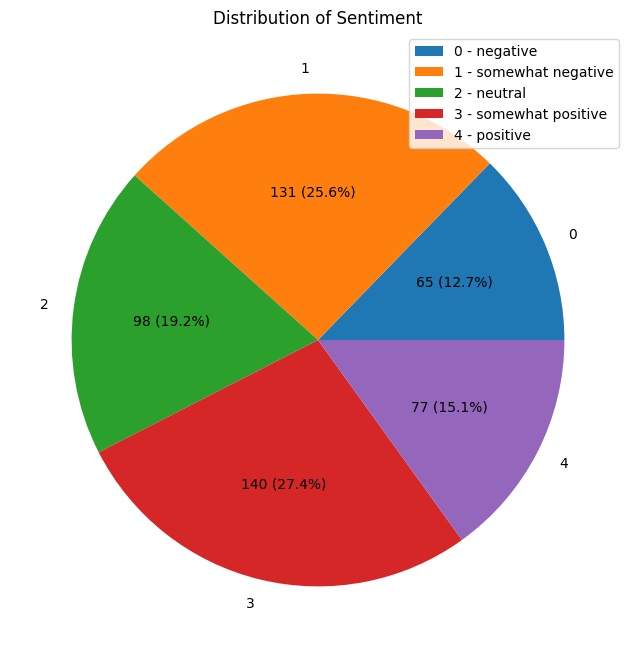

In [ ]:
import matplotlib.pyplot as plt

train_raw_df = train_raw.select('Sentiment').toPandas()
train_value_counts_sorted = train_raw_df['Sentiment'].value_counts().sort_index(ascending=True)

plt.figure(figsize=(8, 8))
_, _, autotexts = plt.pie(train_value_counts_sorted, labels=train_value_counts_sorted.index, autopct='%1.1f%%')
plt.legend(labels=new_labels)

# Add quantity and percentage to each pie slice
for i, autotext in enumerate(autotexts):
    count = train_value_counts_sorted[i]
    percentage = train_value_counts_sorted[i] / train_value_counts_sorted.sum() * 100
    autotext.set_text(f'{count} ({percentage:.1f}%)')

plt.title('Distribution of Sentiment')
plt.show()

## 2. Model Performance

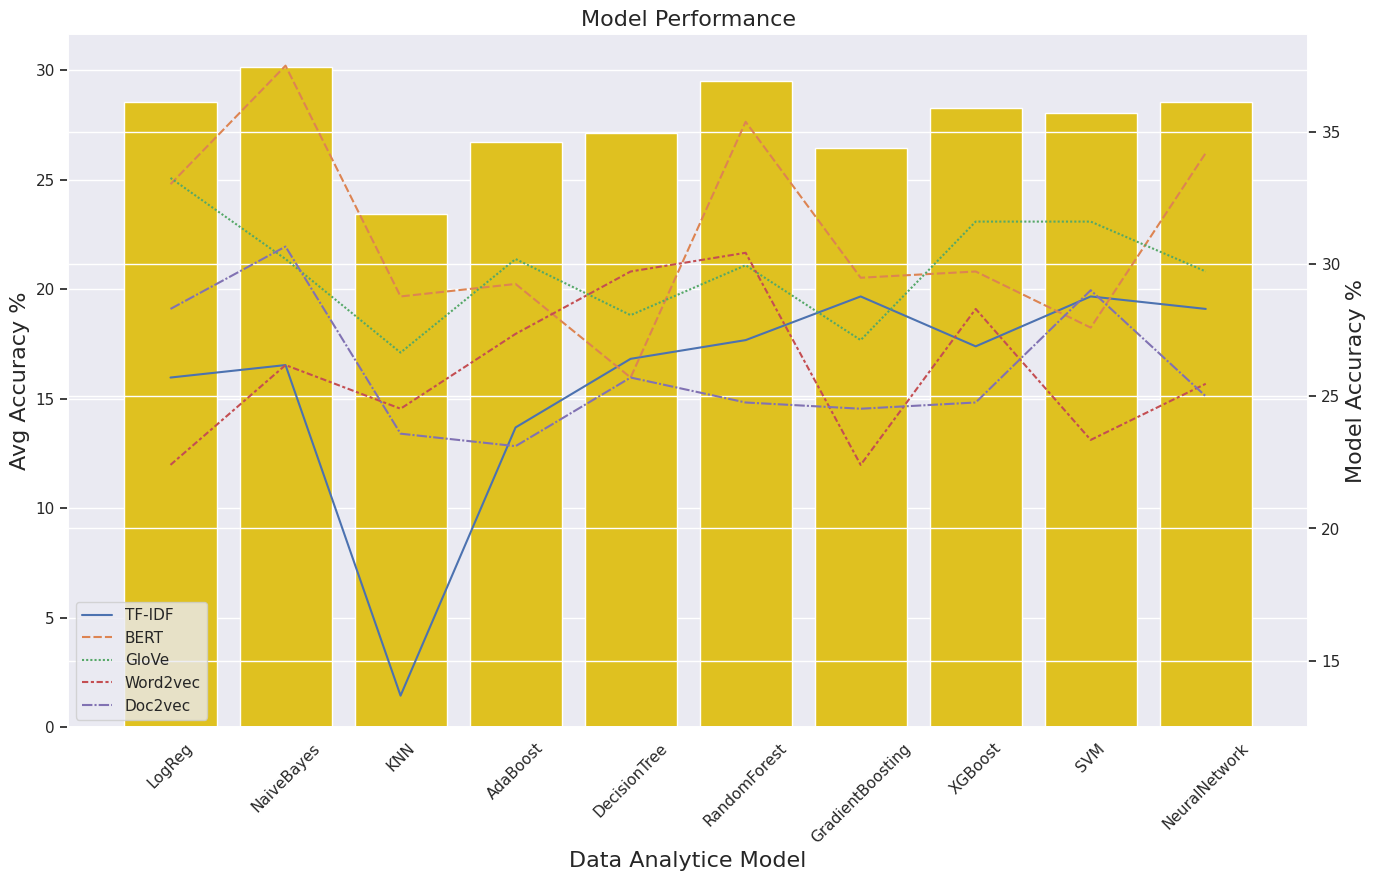

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

fig, ax1 = plt.subplots(figsize=(16,9))
ax1.set_title('Model Performance', fontsize=16)
ax1.tick_params(axis='y')

# create a barplot
ax2 = sns.barplot(data = df.loc["average accuracy"], color = 'gold')
ax2 = ax1.twinx()

# create a line chart
ax2 = sns.lineplot(data = df.iloc[:5,:].T, sort=False)

ax1.set_xlabel('Data Analytice Model', fontsize=16)
ax1.set_ylabel('Avg Accuracy %', fontsize=16)
ax1.set_xticks(range(len(df.columns)))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax2.tick_params(axis='y')
ax2.set_ylabel('Model Accuracy %', fontsize=16)
plt.show()

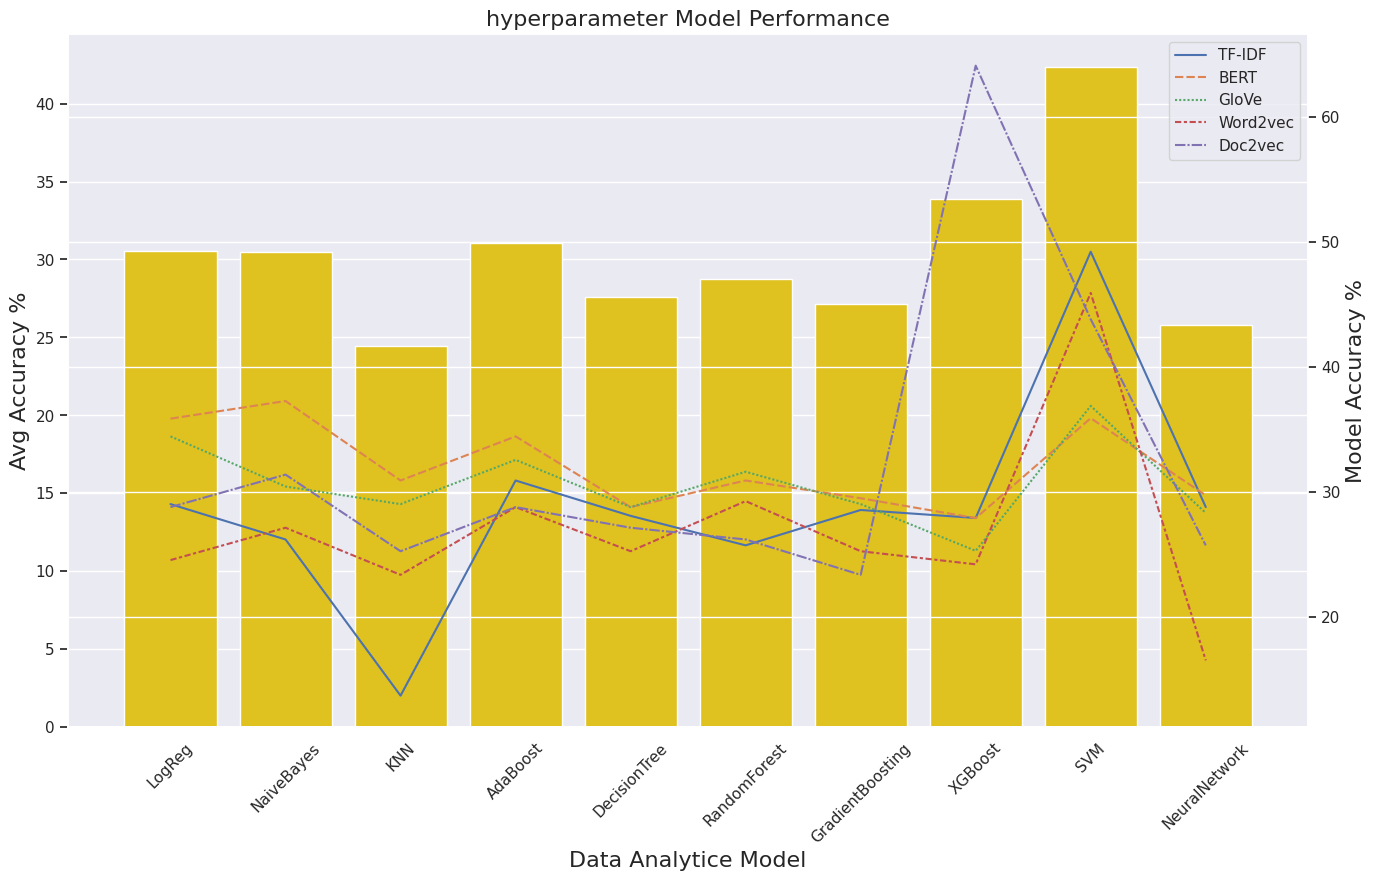

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

fig, ax1 = plt.subplots(figsize=(16,9))
ax1.set_title('hyperparameter Model Performance', fontsize=16)
ax1.tick_params(axis='y')

# create a barplot
ax2 = sns.barplot(data = df_hp.loc["average accuracy"], color = 'gold')
ax2 = ax1.twinx()

# create a line chart
ax2 = sns.lineplot(data = df_hp.iloc[:5,:].T, sort=False)

ax1.set_xlabel('Data Analytice Model', fontsize=16)
ax1.set_ylabel('Avg Accuracy %', fontsize=16)
ax1.set_xticks(range(len(df_hp.columns)))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax2.tick_params(axis='y')
ax2.set_ylabel('Model Accuracy %', fontsize=16)
plt.show()

## 3. Hyperparameters for Logistic Regression

In [ ]:
acc_list = [accuracy_logr_tfidf*100,accuracy_logr_bert*100,accuracy_logr_glove*100,accuracy_logr_Word2vec*100,accuracy_logr_Doc2vec*100]
acc_hp_list = [accuracy_logr_tfidf_hp*100,accuracy_logr_bert_hp*100,accuracy_logr_glove_hp*100,accuracy_logr_Word2vec_hp*100,accuracy_logr_Doc2vec_hp*100]
we_model_list = ['TF-IDF','BERT','GloVe','Word2vec','Doc2vec']
log_hp_df = pd.DataFrame({'model': we_model_list+we_model_list, 'accuracy': acc_list+acc_hp_list, 'accuracy type': ['accuracy']*5+['accuracy after hyperparameter']*5})
log_hp_df

,model,accuracy,accuracy type
0,TF-IDF,25.707547,accuracy
1,BERT,33.018868,accuracy
2,GloVe,33.254717,accuracy
3,Word2vec,22.405660,accuracy
4,Doc2vec,27.594340,accuracy
5,TF-IDF,29.716981,accuracy after hyperparameter
6,BERT,35.849057,accuracy after hyperparameter
7,GloVe,32.311321,accuracy after hyperparameter
8,Word2vec,25.471698,accuracy after hyperparameter
9,Doc2vec,27.594340,accuracy after hyperparameter


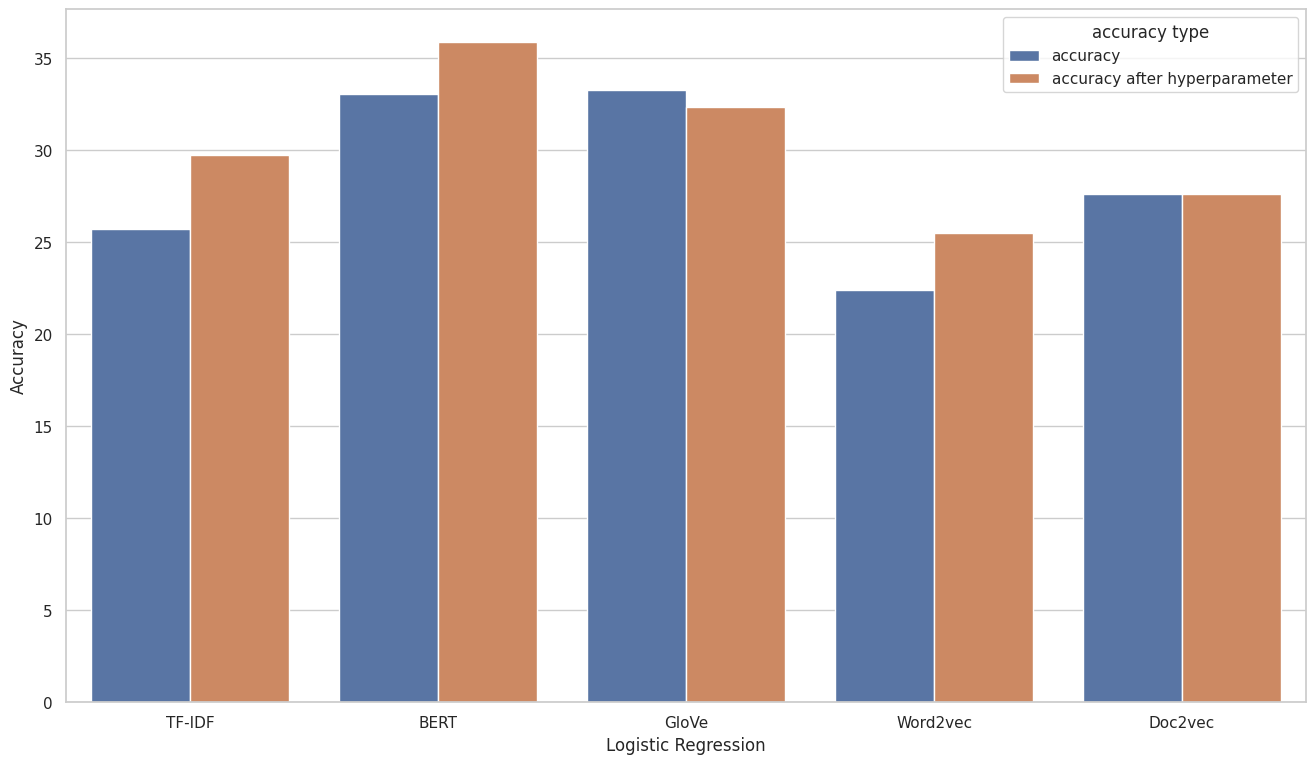

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(16, 9))

sns.barplot(x='model', y='accuracy', hue='accuracy type', data=log_hp_df)

plt.xlabel('Logistic Regression')
plt.ylabel('Accuracy')

plt.show()

## 4. Hyperparameters for Word2vec

In [ ]:
da_model_list = ['LogReg','NaiveBayes','KNN','AdaBoost','DecisionTree','RandomForest','GradientBoosting','XGBoost','SVM','NeuralNetwork']
da_model_abb_list = ['logr','nb','knn','adaBoost','dtc','rdc','gbtc','xgb','svm','mlp']
accuracy_type_list = ['accuracy','accuracy after hyperparameter']
acc_data_list = []
for x in da_model_abb_list:
  temp = 'accuracy_'+x+'_Word2vec'
  temp_hp = temp+'_hp'
  acc_data_list.append(eval(temp)*100)
  acc_data_list.append(eval(temp_hp)*100)

da_model_list_double = []
for x in da_model_list:
  da_model_list_double.append(x)
  da_model_list_double.append(x)

word2vec_hp_df = pd.DataFrame({'model': da_model_list_double, 'accuracy': acc_data_list, 'accuracy type': accuracy_type_list*10})
word2vec_hp_df

,model,accuracy,accuracy type
0,LogReg,27.122642,accuracy
1,LogReg,25.235849,accuracy after hyperparameter
2,NaiveBayes,25.943396,accuracy
3,NaiveBayes,25.943396,accuracy after hyperparameter
4,KNN,23.349057,accuracy
5,KNN,23.349057,accuracy after hyperparameter
6,AdaBoost,30.660377,accuracy
7,AdaBoost,30.660377,accuracy after hyperparameter
8,DecisionTree,27.830189,accuracy
9,DecisionTree,25.943396,accuracy after hyperparameter


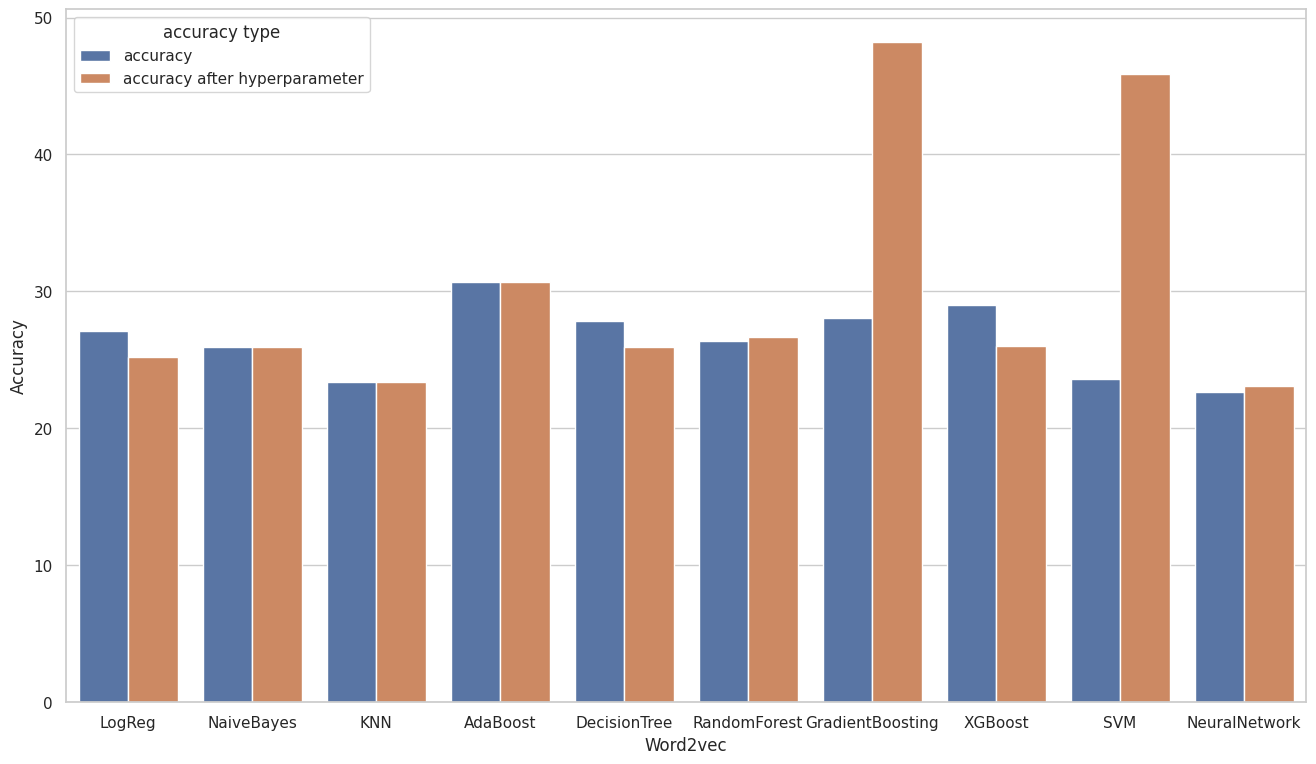

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(16, 9))

sns.barplot(x='model', y='accuracy', hue='accuracy type', data=word2vec_hp_df)

plt.xlabel('Word2vec')
plt.ylabel('Accuracy')

plt.show()

## 5. Word Cloud Diagram

In [ ]:
# !pip install wordcloud

In [ ]:
train_negative = train_cleaned_npl.filter(train_cleaned_npl['Sentiment'].isin(0,1))
train_negative.show(1)

train_positive = train_cleaned_npl.filter(train_cleaned_npl['Sentiment'].isin(3,4))
train_positive.show(1)

+--------+----------+--------------------+---------+--------------------+--------------------+
|PhraseId|SentenceId|              Phrase|Sentiment|          normalized|      Phrase_cleaned|
+--------+----------+--------------------+---------+--------------------+--------------------+
|  144934|      7871|An unremittingly ...|        0|[an, unremittingl...|[unremittingly, u...|
+--------+----------+--------------------+---------+--------------------+--------------------+
only showing top 1 row

+--------+----------+--------------------+---------+--------------------+--------------------+
|PhraseId|SentenceId|              Phrase|Sentiment|          normalized|      Phrase_cleaned|
+--------+----------+--------------------+---------+--------------------+--------------------+
|   93942|      4902|As the princess ,...|        3|[as, the, princes...|[princess, sorvin...|
+--------+----------+--------------------+---------+--------------------+--------------------+
only showing top 1 row



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF

# define the tokenizer and CountVectorizer
tf  = CountVectorizer(inputCol="Phrase_cleaned", outputCol="tf") # CountVectorizer count word freq of each doc (i.e., TF)
idf = IDF(inputCol="tf", outputCol="tfidf")

# Alternative: One-step pipeline
pipeline_tfidf = Pipeline(stages=[tf, idf])

model_train_negative = pipeline_tfidf.fit(train_negative)
model_train_positive = pipeline_tfidf.fit(train_positive)

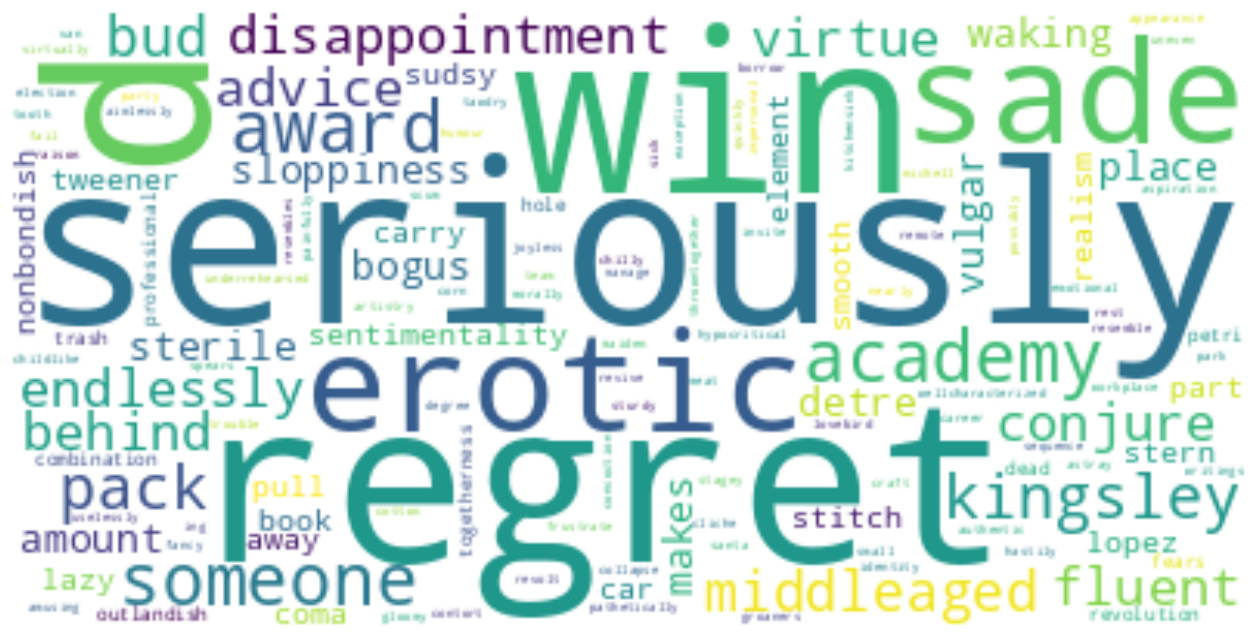

In [ ]:
## Word cloud diagram for negative data

# Extract vocabularies from CountVectorizerModel
vocab_list_ng = model_train_negative.stages[0].vocabulary
# Extract IDF weights from IDFModel
idf_weights_ng = model_train_negative.stages[1].idf.toArray()
# Create a dictionary of terms and weights
terms_idf_ng = dict(zip(vocab_list_ng, idf_weights_ng))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_ng = WordCloud(background_color='white')
wordcloud_ng.generate_from_frequencies(terms_idf_ng)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud_ng, interpolation='bilinear')
plt.axis('off')
plt.show()

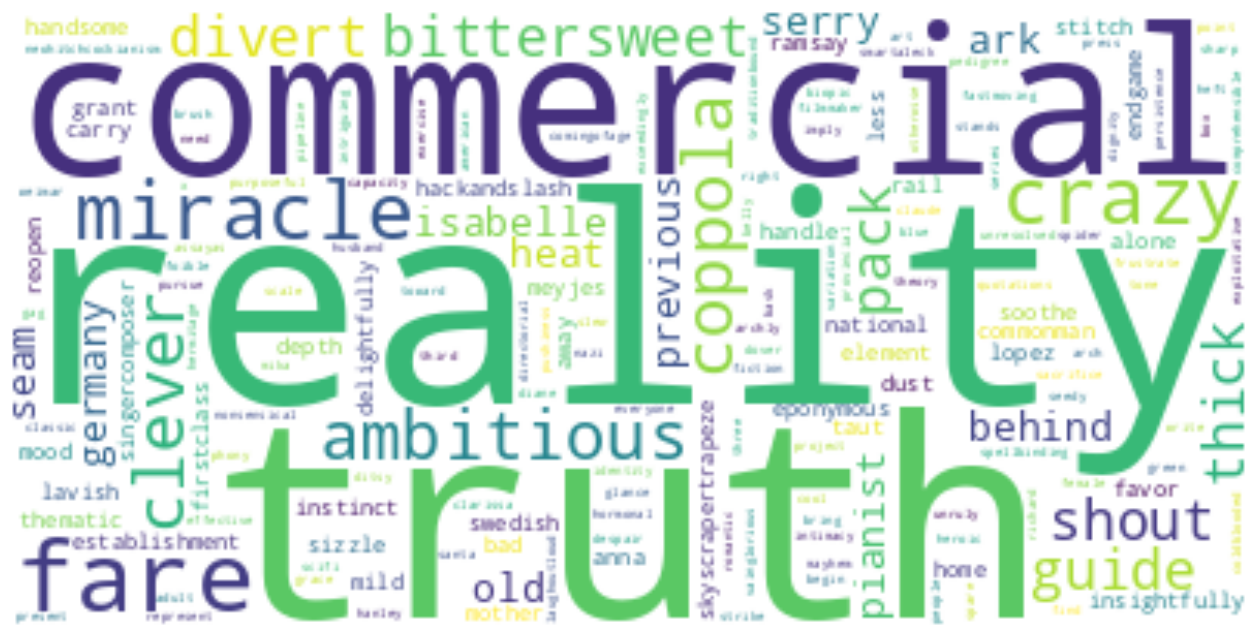

In [ ]:
## Word cloud diagram for positive data

# Extract vocabularies from CountVectorizerModel
vocab_list_ps = model_train_positive.stages[0].vocabulary
# Extract IDF weights from IDFModel
idf_weights_ps = model_train_positive.stages[1].idf.toArray()
# Create a dictionary of terms and weights
terms_idf_ps = dict(zip(vocab_list_ps, idf_weights_ps))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_ps = WordCloud(background_color='white')
wordcloud_ps.generate_from_frequencies(terms_idf_ps)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud_ps, interpolation='bilinear')
plt.axis('off')
plt.show()

## Summarize

1. In sentiment, the number of negative and positive is the least.
2. For movie reviews with negative emotions, **"seriously"**, **"regret"** and **"win"** are the words that appear most frequently.
3. For movie reviews with positive emotions, **"reality"**, **"truth"** and **"commercial"** are the words that appear most frequently.

# Improve Baseline Model
1. Use NLTK to clean data

2. Hyperarameters

3. Use MinMax Scaler to scale the feature values ​​to the same range, thereby eliminating the difference in magnitude between different features.

4. Model Ensemble

## NLTK

### Remove stopwords

In [ ]:
from nltk.corpus import stopwords

def remove_stops(data_str):
    # expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

### Normalization

In [ ]:
import re, string

def normalize(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    # punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    # data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    return data_str

### Lemmatization

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatize(data_str):
    cleaned_words = []
    lmtzr = WordNetLemmatizer()
    word_token = nltk.word_tokenize(data_str) ## word segmentation
    tagged_words = nltk.pos_tag(word_token) ## part-of-speech tagging
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        cleaned_words.append(lemma)
    return cleaned_words

### Data cleaning -- NLTK
Remove Stopwords, Normalization, Lemmatization

In [ ]:
def data_clean(text):
  remove_stops_text = remove_stops(text) ## Remove Stopwords
  normalized_text = normalize(remove_stops_text) ## Normalization
  lmtzr_word = lemmatize(normalized_text) ## Lemmatization
  return lmtzr_word

In [ ]:
## create UDF function
data_clean_udf = udf(data_clean, ArrayType(StringType()))

In [ ]:
## Train data
train_cleaned_nltk = train_raw.withColumn('Phrase_cleaned', data_clean_udf(train_raw['Phrase']))
train_cleaned_nltk.show(5, truncate=False)
train_cleaned_nltk = train_cleaned_nltk.select('PhraseId','SentenceId','Phrase_cleaned','Sentiment')

+--------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------------------------------------------------------------------------------------------------------------------------------------------+
|PhraseId|SentenceId|Phrase                                                                                                                                                                                      |Sentiment|Phrase_cleaned                                                                                                                                  |
+--------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------------------------------------------

In [ ]:
## Text data
test_cleaned_nltk = test_raw.withColumn('Phrase_cleaned', data_clean_udf(test_raw['Phrase']))
test_cleaned_nltk.show(5, truncate=False)
test_cleaned_nltk = test_cleaned_nltk.select('PhraseId','SentenceId','Phrase_cleaned','Sentiment')

+--------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|PhraseId|SentenceId|Phrase                                                                                                                                                                       |Sentiment|Phrase_cleaned                                                                                                                                    |
+--------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------------------------------------------------------

### Apply on Baseline

In [ ]:
from pyspark.ml.feature import Word2Vec
Word2vec = Word2Vec()\
      .setInputCol('Phrase_cleaned')\
      .setOutputCol('word_vectors')\
      .setVectorSize(100)\
      .setMinCount(5)

model_Word2vec = Word2vec.fit(train_cleaned_nltk)

train_Word2vec_nltk = model_Word2vec.transform(train_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')
test_Word2vec_nltk = model_Word2vec.transform(test_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')

In [ ]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')
model_logr_nltk = logr.fit(train_Word2vec_nltk)
# Make predictions.
predictions_logr_nltk = model_logr_nltk.transform(test_Word2vec_nltk)
predictions_logr_nltk.select("features", "label", "prediction").show(5)
# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logr_nltk = evaluator.evaluate(predictions_logr_nltk)
print('A Logistic Regression had an accuracy of: {0:2.2f}%'.format(accuracy_logr_nltk*100))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[-4.2482131325146...|    0|       0.0|
|[3.62203462928947...|    0|       1.0|
|[7.53407948650419...|    0|       3.0|
|[0.00117180560482...|    0|       2.0|
|[-9.6861768646964...|    0|       3.0|
+--------------------+-----+----------+
only showing top 5 rows

A Logistic Regression had an accuracy of: 27.86%


## Baseline Hyperparameter

### Word2vec Hyperparameter

In [ ]:
def word2vec_hp(i):
  Word2vec = Word2Vec()\
    .setInputCol('Phrase_cleaned')\
    .setOutputCol('word_vectors')\
    .setVectorSize(i)\
    .setMinCount(5)
  model_Word2vec = Word2vec.fit(train_cleaned_nltk)
  train_Word2vec_nltk = model_Word2vec.transform(train_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')
  test_Word2vec_nltk = model_Word2vec.transform(test_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')

  logr = LogisticRegression(featuresCol='features', labelCol='label')
  model_logr_nltk = logr.fit(train_Word2vec_nltk)
  predictions_logr_nltk = model_logr_nltk.transform(test_Word2vec_nltk)
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy_logr_nltk = evaluator.evaluate(predictions_logr_nltk)
  acc_str = "{0:.2f}%".format(accuracy_logr_nltk * 100)
  print(i, acc_str+'%')

for i in range(50,151,10):
    word2vec_hp(i)

50 26.98%%
60 28.74%%
70 25.22%%
80 26.10%%
90 26.10%%
100 27.86%%
110 22.29%%
120 25.51%%
130 26.10%%
140 25.22%%
150 26.98%%


When VectorSize equal to **60**, the model has the highest accuracy -- **28.74%**.

In [ ]:
## set VectorSize equal to 60, re-execute word2vec
from pyspark.ml.feature import Word2Vec
Word2vec = Word2Vec()\
      .setInputCol('Phrase_cleaned')\
      .setOutputCol('word_vectors')\
      .setVectorSize(60)\
      .setMinCount(5)

model_Word2vec = Word2vec.fit(train_cleaned_nltk)

train_Word2vec_nltk = model_Word2vec.transform(train_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')
test_Word2vec_nltk = model_Word2vec.transform(test_cleaned_nltk)\
             .selectExpr('word_vectors AS features', 'Sentiment AS label')

### Logistic Regression Hyperparameter

In [ ]:
## Word2vec
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(logr.regParam, [0.01, 0.0]) \
    .addGrid(logr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
crossval = CrossValidator(estimator=logr,
              estimatorParamMaps=param_grid,
              evaluator=evaluator,
              numFolds=5)
logr = LogisticRegression(featuresCol='features', labelCol='label')
cv_model = crossval.fit(train_Word2vec_nltk)
predictions = cv_model.transform(test_Word2vec_nltk)
accuracy_logr_Word2vec_hp = evaluator.evaluate(predictions)
print('Best Logistic Regression with Word2vec accuracy: {0:2.2f}%'.format(accuracy_logr_Word2vec_hp * 100))
# get the best hyper-parameter
best_model = cv_model.bestModel
best_reg_param = best_model.getOrDefault('regParam')
best_elastic_net_param = best_model.getOrDefault('elasticNetParam')
print('Best model hyperparameters:')
print('- regParam:', best_reg_param)
print('- elasticNetParam:', best_elastic_net_param)

Best Logistic Regression with Word2vec accuracy: 29.91%
Best model hyperparameters:
- regParam: 0.01
- elasticNetParam: 0.0


## MinMaxscaler

In [ ]:
from pyspark.ml.feature import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Scale the data
scaler_model_train = scaler.fit(train_Word2vec_nltk)
train_Word2vec_nltk_scaled = scaler_model_train.transform(train_Word2vec_nltk)
train_Word2vec_nltk_scaled = train_Word2vec_nltk_scaled.drop("features")
train_Word2vec_nltk_scaled = train_Word2vec_nltk_scaled.withColumnRenamed("scaled_features", "features").select('features', 'label')

test_Word2vec_nltk_scaled = scaler_model_train.transform(test_Word2vec_nltk)
test_Word2vec_nltk_scaled = test_Word2vec_nltk_scaled.drop("features")
test_Word2vec_nltk_scaled = test_Word2vec_nltk_scaled.withColumnRenamed("scaled_features", "features").select('features', 'label')

In [ ]:
logr = LogisticRegression(featuresCol='features', labelCol='label', regParam=0.01, elasticNetParam=0.0)
model_logr_nltk = logr.fit(train_Word2vec_nltk_scaled)
predictions_logr_nltk = model_logr_nltk.transform(test_Word2vec_nltk_scaled)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_logr_nltk_scaled = evaluator.evaluate(predictions_logr_nltk)
print('After MinMaxScaler, Logistic Regression with Word2vec accuracy: {0:2.2f}%'.format(accuracy_logr_nltk_scaled * 100))

After MinMaxScaler, Logistic Regression with Word2vec accuracy: 29.91%


## Model Ensemble

LogisticRegression + RandomForestClassifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

rf = RandomForestClassifier(numTrees=30, maxDepth=10, featuresCol='features', labelCol='label',
                            predictionCol='prediction_rf', rawPredictionCol='rawPrediction_rf', probabilityCol='probability_rf')

rf2 =LogisticRegression(maxIter=20, regParam=0.01, elasticNetParam=0.0, featuresCol='probability_rf', labelCol='label',
                            predictionCol='prediction_rf2', rawPredictionCol='rawPrediction_rf2', probabilityCol='probability_rf2')

# evaluator, also need to rename to match the rf output name (i.e., prediction_rf)
evaluator= MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction_rf2", metricName="accuracy")

pipeline = Pipeline(stages = [rf, rf2]) # first use rf to predict, then lr take the prediction
model = pipeline.fit(train_Word2vec_nltk_scaled)
result = model.transform(test_Word2vec_nltk_scaled)

ensemble_acc = evaluator.evaluate(result)
print('A ensemble model had an accuracy of: {0:2.2f}%'.format(ensemble_acc*100))

A ensemble model had an accuracy of: 30.21%


## Summarize

1. Compared with npl, the accuracy of the model obtained by using NLTK to clean the data has a better improved.
2. Hyperparameters provide a more significant improvement in accuracy compared to MinMaxscaler and Model Ensemble.